In [2]:
import pandas as pd
import numpy as np
import json
from itertools import chain
import os
import matplotlib.pyplot as plt
from copy import deepcopy

from preprocessing_utils import ScaleData, SplitData, n_lag_return, LogReturn2SimpleReturn
from sklearn.preprocessing import MinMaxScaler

In [3]:
def GetResultsFromJSON(ticker, fold, exp_dir):
    result_dir = f"{exp_dir}/fold{fold}/{ticker}/model_results.json"
    with open(result_dir, 'r') as f:
        results = json.load(f)
    return results

def FetchBestResults(results):
    best_idx = np.argmin(results['val_losses'])
    best_results = {key: value[best_idx] for key, value in results.items()}
    return best_results

In [4]:
stock_tickers = pd.read_csv('data/SP500_tickers_clean.csv', header=0).Ticker.unique()
stock_data = pd.read_csv('data/SP500_stock_prices_log_clean_3monthreturn.csv', index_col=0, parse_dates=True)

In [5]:
TEST_SPLITS = ['2018-10-01', 
               '2019-01-01', 
               '2019-04-01', 
               '2019-07-01', 
               '2019-10-01']


In [7]:
# get the experiment names
exp_path = 'experiments/'
exp_names = os.listdir(exp_path)
exp_names

['exp_cycl_1dh',
 'exp_cycl_1dH',
 'exp_cycl_1Dh',
 'exp_cycl_1DH',
 'exp_plat_2Dh',
 'exp_plat_2dh',
 'exp_plat_2DH',
 'exp_cycl_2Dh',
 'exp_cycl_2dH',
 'exp_cycl_2DH',
 'exp_cycl_2dh',
 'exp_plat_1DH',
 'exp_plat_1Dh',
 'exp_plat_1dH',
 'exp_plat_1dh']

In [8]:
pred_index_df = pd.DataFrame(index=stock_data.index[stock_data.index >= TEST_SPLITS[4]].unique()).iloc[:63]
pred_index_df

Empty DataFrame
Columns: []
Index: [2019-10-01 00:00:00, 2019-10-02 00:00:00, 2019-10-03 00:00:00, 2019-10-04 00:00:00, 2019-10-07 00:00:00, 2019-10-08 00:00:00, 2019-10-09 00:00:00, 2019-10-10 00:00:00, 2019-10-11 00:00:00, 2019-10-14 00:00:00, 2019-10-15 00:00:00, 2019-10-16 00:00:00, 2019-10-17 00:00:00, 2019-10-18 00:00:00, 2019-10-21 00:00:00, 2019-10-22 00:00:00, 2019-10-23 00:00:00, 2019-10-24 00:00:00, 2019-10-25 00:00:00, 2019-10-28 00:00:00, 2019-10-29 00:00:00, 2019-10-30 00:00:00, 2019-10-31 00:00:00, 2019-11-01 00:00:00, 2019-11-04 00:00:00, 2019-11-05 00:00:00, 2019-11-06 00:00:00, 2019-11-07 00:00:00, 2019-11-08 00:00:00, 2019-11-11 00:00:00, 2019-11-12 00:00:00, 2019-11-13 00:00:00, 2019-11-14 00:00:00, 2019-11-15 00:00:00, 2019-11-18 00:00:00, 2019-11-19 00:00:00, 2019-11-20 00:00:00, 2019-11-21 00:00:00, 2019-11-22 00:00:00, 2019-11-25 00:00:00, 2019-11-26 00:00:00, 2019-11-27 00:00:00, 2019-11-29 00:00:00, 2019-12-02 00:00:00, 2019-12-03 00:00:00, 2019-12-04 00:00:00, 2019-12-05 00:00:00, 2019-12-06 00:00:00, 2019-12-09 00:00:00, 2019-12-10 00:00:00, 2019-12-11 00:00:00, 2019-12-12 00:00:00, 2019-12-13 00:00:00, 2019-12-16 00:00:00, 2019-12-17 00:00:00, 2019-12-18 00:00:00, 2019-12-19 00:00:00, 2019-12-20 00:00:00, 2019-12-23 00:00:00, 2019-12-24 00:00:00, 2019-12-26 00:00:00, 2019-12-27 00:00:00, 2019-12-30 00:00:00]

[63 rows x 0 columns]

In [9]:
scaler = MinMaxScaler()
target_scaler = deepcopy(scaler)
ticker_rows_train = stock_data.loc[stock_data.index < TEST_SPLITS[4]].copy()
target_columns = ['log_return_3m']
ticker_rows_train[target_columns] = target_scaler.fit(ticker_rows_train[target_columns])
scale_range = np.array(target_scaler.data_max_[0] - target_scaler.data_min_[0])

In [11]:
# Empty list to store each ticker's results as a series
mean_list = {}
std_list = {}

# for exp_name in exp_names[0:2]:

for ticker in stock_tickers:
    exp_dir = os.path.join(exp_path, 'exp_cycl_1dh')
    results = GetResultsFromJSON(ticker, 4, exp_dir)
    BestResults = FetchBestResults(results) # val_means is 63 long, so for each day we find the best tickers

    unscaled_means = scale_range * (BestResults['val_means'])
    unscaled_stds = scale_range * (BestResults['val_stds'])

    mean_list[ticker] = LogReturn2SimpleReturn(unscaled_means)
    std_list[ticker] = LogReturn2SimpleReturn(unscaled_stds)

pred_mean_df = pd.DataFrame(mean_list, index=pred_index_df.index)
pred_std_df = pd.DataFrame(std_list, index=pred_index_df.index)

pred_mean_df

MMM       AOS       ABT      ABBV       ACN      ATVI  \
Date                                                                     
2019-10-01 -0.429058 -0.349006 -0.371876  3.034988 -0.617444  0.500194   
2019-10-02 -0.470125 -0.376012 -0.416890  2.922782 -0.597513  0.538641   
2019-10-03 -0.495339 -0.388687 -0.402045  2.528689 -0.602685  0.395743   
2019-10-04 -0.474567 -0.409023 -0.421848  3.141680 -0.606948  0.567422   
2019-10-07 -0.483070 -0.376970 -0.422421  2.929599 -0.618567  0.592742   
...              ...       ...       ...       ...       ...       ...   
2019-12-23 -0.404222 -0.351402 -0.398271  2.706234 -0.616370  0.496059   
2019-12-24 -0.409337 -0.406375 -0.399333  3.307549 -0.620168  0.500851   
2019-12-26 -0.371350 -0.415735 -0.320028  3.667278 -0.617350  0.417548   
2019-12-27 -0.370541 -0.372471 -0.377127  3.130870 -0.618600  0.421190   
2019-12-30 -0.416586 -0.393277 -0.414248  3.045016 -0.618165  0.407923   

                 ADM      ADBE       ADP       AAP  ...       WTW       GWW  \
Date                                                ...                       
2019-10-01  1.083417 -0.574688  0.221074 -0.495494  ... -0.223681  0.131666   
2019-10-02  1.102885 -0.619864  0.186840 -0.467003  ... -0.242112  0.010373   
2019-10-03  1.098416 -0.602210  0.276547 -0.475938  ... -0.250409 -0.015436   
2019-10-04  1.126123 -0.592248  0.241702 -0.490701  ... -0.262923  0.045655   
2019-10-07  1.032557 -0.607386  0.272904 -0.488911  ... -0.238306  0.081150   
...              ...       ...       ...       ...  ...       ...       ...   
2019-12-23  1.274169 -0.620416  0.315079 -0.451054  ... -0.234319  0.143051   
2019-12-24  1.122398 -0.612111  0.217129 -0.459858  ... -0.325746 -0.008252   
2019-12-26  1.168728 -0.597780  0.146856 -0.471494  ... -0.299510  0.161420   
2019-12-27  1.191057 -0.601572  0.166167 -0.539372  ... -0.300688  0.065333   
2019-12-30  1.167522 -0.572000  0.253440 -0.514355  ... -0.330199  0.073032   

                WYNN       XEL       XYL       YUM      ZBRA       ZBH  \
Date                                                                     
2019-10-01 -0.670597  1.059703  0.226077  1.525463 -0.473175 -0.475011   
2019-10-02 -0.663251  1.002832  0.212823  1.508144 -0.472256 -0.487824   
2019-10-03 -0.666637  1.127750  0.167288  1.516254 -0.481944 -0.529594   
2019-10-04 -0.676252  1.064012  0.055176  1.442782 -0.477830 -0.482776   
2019-10-07 -0.657384  1.003574  0.176676  1.385933 -0.477763 -0.503484   
...              ...       ...       ...       ...       ...       ...   
2019-12-23 -0.701770  0.941564  0.192255  1.604415 -0.450340 -0.556152   
2019-12-24 -0.712588  0.895368  0.109389  1.570353 -0.441841 -0.557021   
2019-12-26 -0.699537  0.920347  0.217328  1.875108 -0.468964 -0.585542   
2019-12-27 -0.700275  0.832211  0.262398  1.505378 -0.478598 -0.595010   
2019-12-30 -0.708596  0.891792  0.254431  1.520087 -0.490297 -0.564583   

                ZION       ZTS  
Date                            
2019-10-01 -0.230857  0.366358  
2019-10-02 -0.283583  0.381043  
2019-10-03 -0.257726  0.244063  
2019-10-04 -0.260621  0.340392  
2019-10-07 -0.277830  0.337195  
...              ...       ...  
2019-12-23 -0.334265  0.279479  
2019-12-24 -0.341268  0.233215  
2019-12-26 -0.337461  0.297733  
2019-12-27 -0.337636  0.354316  
2019-12-30 -0.330614  0.272144  

[63 rows x 483 columns]

<Axes: xlabel='Date'>

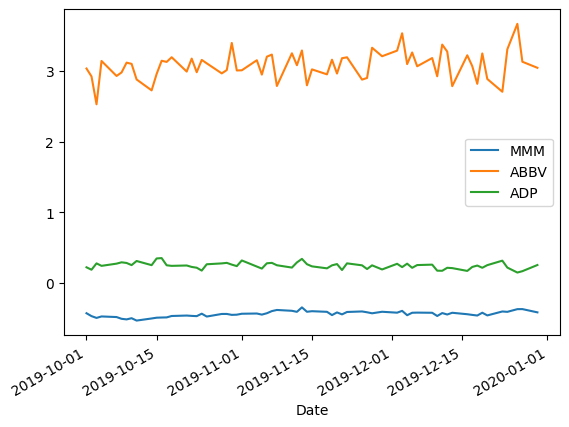

In [12]:
pred_mean_df[['MMM', 'ABBV', 'ADP']].plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'IPG', 'COO', 'WM', 'MDT', 'HII', 'JKHY', 'EXPE', 'INCY', 'DPZ'] [0.33969453 0.16822376 0.12603053 0.09589508 0.08618871 0.07970559
 0.04412054 0.03259491 0.02341017 0.00413618] 1.5135628625384032 0.08486670033494953


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['ETSY', 'TSLA', 'ABBV', 'GL', 'LYV', 'PCAR', 'DISH', 'ZTS', 'OMC', 'TRGP'] [0.33316362 0.16573075 0.13607343 0.10815034 0.09838997 0.07303465
 0.06160709 0.01782864 0.00544515 0.00057635] 2.150308904175386 0.11536798604483865


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'XEL', 'LYV', 'CTLT', 'FMC', 'RF', 'EOG', 'VTRS', 'CRL', 'CAH'] [0.29734248 0.18680777 0.12658989 0.09026261 0.08249987 0.07701709
 0.05940602 0.03428343 0.02643307 0.01935778] 1.5999944900235439 0.09368916068273098


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['KR', 'KDP', 'GE', 'CAG', 'EA', 'EIX', 'ISRG', 'IBM', 'IFF', 'MAA'] [0.30037199 0.21630163 0.19161101 0.08042997 0.07660483 0.04914575
 0.03425118 0.01966316 0.01793401 0.01368647] 1.209262064681932 0.06320885299608436


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['LYB', 'COP', 'VFC', 'KDP', 'FANG', 'ZBRA', 'LOW', 'SEDG', 'MCHP', 'NEE'] [0.46614186 0.1440168  0.11850933 0.08664709 0.07301056 0.04314885
 0.03956177 0.01753416 0.00814726 0.0032823 ] 1.2206969634750295 0.07994035138119575


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['HSIC', 'KDP', 'PKG', 'RCL', 'EQR', 'ALK', 'LYV', 'PEG', 'JPM', 'JNPR'] [0.31162647 0.14491773 0.13664834 0.1249783  0.11847349 0.05761849
 0.0458599  0.04465226 0.01238636 0.00283868] 1.307411066248838 0.07882137855954809


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['LYB', 'HAS', 'FDS', 'FSLR', 'ROL', 'ETN', 'MCD', 'IT', 'PM', 'UDR'] [0.42952465 0.21219708 0.12434391 0.05196088 0.05169091 0.04415241
 0.04156743 0.02810498 0.0114147  0.00504306] 1.436650003352513 0.08027929563016917


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['AVY', 'LYB', 'V', 'PNC', 'PAYC', 'GILD', 'KEYS', 'SJM', 'PAYX', 'AES'] [0.28271242 0.16336892 0.13442601 0.11018521 0.10753518 0.06576684
 0.05403746 0.04582445 0.03069471 0.0054488 ] 1.1719717670365721 0.06694612473544591


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['LYB', 'NWSA', 'LH', 'GEN', 'JCI', 'T', 'RHI', 'BLK', 'INCY', 'IQV'] [0.3647242  0.14372549 0.1138183  0.09430594 0.07655192 0.07617429
 0.06988854 0.02524645 0.02370591 0.01185893] 1.3568509438099061 0.08290511696943123


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IPG', 'GD', 'FANG', 'IRM', 'CDNS', 'MKTX', 'DPZ', 'MSFT', 'TSCO', 'IQV'] [0.40499073 0.19931105 0.09363001 0.0922277  0.0861707  0.05936993
 0.05156815 0.00635253 0.00563547 0.00074374] 1.51908537615508 0.086147822998758


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['ABC', 'LYB', 'RF', 'ABBV', 'CDW', 'ESS', 'F', 'SHW', 'NWSA', 'NWS'] [0.25894304 0.25617859 0.14937589 0.14103602 0.05976383 0.05184297
 0.03603164 0.03253701 0.0075512  0.00673982] 1.585574660013764 0.07726825604525167


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['AVY', 'IRM', 'ADI', 'LYB', 'SBUX', 'HCA', 'HRL', 'CE', 'LIN', 'GE'] [0.23153002 0.17844203 0.15920354 0.13452559 0.09065758 0.07185526
 0.07138627 0.03516985 0.02197071 0.00525915] 1.0451048269622176 0.052903080241744074


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['LYB', 'IRM', 'GWW', 'CI', 'STX', 'ED', 'SWKS', 'PCAR', 'AFL', 'HCA'] [0.36241845 0.3126121  0.08751504 0.06021434 0.04287074 0.03530968
 0.03091884 0.0303743  0.02559444 0.01217207] 1.6763494348058647 0.09215189344520566


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['BLK', 'IPG', 'DPZ', 'NDSN', 'HSY', 'MRO', 'BBY', 'RF', 'TXN', 'AIZ'] [0.29526231 0.19577191 0.14142673 0.10650076 0.09323813 0.08614627
 0.03775266 0.02180311 0.01505256 0.00704555] 1.4530619795017932 0.08764622202321135


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['AVY', 'ES', 'ALK', 'LYB', 'ILMN', 'POOL', 'BKR', 'ABBV', 'BEN', 'FDS'] [0.29413617 0.13447737 0.1119927  0.10573319 0.09792898 0.09468749
 0.05591789 0.04440693 0.03361523 0.02710404] 1.2069439160127984 0.07407756741508566


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IPG', 'KR', 'MOS', 'EXR', 'PODD', 'SLB', 'TMUS', 'CRM', 'DOV', 'PLD'] [0.23751153 0.18873467 0.12318642 0.1225003  0.10332091 0.09774937
 0.05330393 0.04416072 0.0232377  0.00629444] 1.2481429818888017 0.07749307337272177
['KR', 'LYB', 'AJG', 'LNT', 'DFS', 'VRSK', 'TJX', 'HRL', 'FMC', 'VLO'] [0.34773476 0.29654579 0.09828886 0.05685885 0.04307523 0.04176494
 0.03941385 0.03505685 0.02220367 0.0190572 ] 1.0320043946463284 0.06397395146940846


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'GE', 'FISV', 'WHR', 'ABC', 'PCAR', 'ELV', 'FRT', 'STX', 'TRV'] [0.22369822 0.18558518 0.14610347 0.12146266 0.11530434 0.10035343
 0.03800007 0.03334203 0.02597474 0.01017587] 1.5571575280738643 0.08187017577640315


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['HSIC', 'JPM', 'KR', 'C', 'NKE', 'CF', 'PAYC', 'RMD', 'NTAP', 'CINF'] [0.27326963 0.24693253 0.16594221 0.1119472  0.07657174 0.04348994
 0.03769261 0.03239187 0.00993825 0.00182401] 1.3747675642996633 0.07316726844243104


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'KDP', 'ABT', 'DIS', 'GOOGL', 'GD', 'GPN', 'MGM', 'AMGN', 'CSGP'] [0.38239548 0.21183391 0.11557848 0.09215816 0.07957541 0.05801046
 0.03415391 0.01558507 0.00692003 0.00378908] 1.5710170332663829 0.08777047882548546


/tmp/ipykernel_27913/1972102008.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'HUM', 'RVTY', 'TAP', 'MPWR', 'WBA', 'EFX', 'CMA', 'GL', 'HES'] [0.53487469 0.12317737 0.12260651 0.08817978 0.06302837 0.02934883
 0.02753338 0.00485029 0.00481944 0.00158131] 1.3816342481009174 0.09092507772656351


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['HSIC', 'JPM', 'NEE', 'CTRA', 'EOG', 'TT', 'SBAC', 'BLK', 'BWA', 'O'] [0.57414925 0.14455518 0.07879798 0.06448787 0.04848258 0.02727685
 0.02229234 0.01938461 0.01906413 0.0015092 ] 1.3389443009425526 0.07851082988521361


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['PCAR', 'CRL', 'SBUX', 'A', 'PNC', 'EA', 'AWK', 'WRB', 'FMC', 'TRV'] [0.20936798 0.18764821 0.17103024 0.13063801 0.12564036 0.06393426
 0.04042472 0.03585157 0.03434516 0.00111948] 2.2078329429490027 0.1389354319100304


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['KR', 'IPG', 'NDSN', 'PNW', 'FRT', 'C', 'WAT', 'COO', 'PEG', 'FAST'] [0.39386858 0.22281018 0.09907221 0.09349541 0.04591214 0.0375735
 0.03661918 0.03622496 0.03006317 0.00436065] 1.4316468609364197 0.07996382804416147


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['JPM', 'ABBV', 'PODD', 'RMD', 'GIS', 'VZ', 'A', 'LMT', 'ANET', 'FFIV'] [0.31288249 0.29715798 0.1517801  0.08183143 0.05223855 0.05203893
 0.02965841 0.01427769 0.00629002 0.00184438] 2.18160592691973 0.1291927157684884


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['HSIC', 'DPZ', 'FDX', 'PCAR', 'GL', 'TFC', 'BEN', 'LLY', 'SPGI', 'TJX'] [0.204237   0.18151492 0.14278028 0.13509959 0.1229747  0.10126124
 0.04353031 0.03366014 0.02644079 0.00850103] 1.89791687076249 0.11227951171577412


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['AVY', 'ABC', 'PCAR', 'CMCSA', 'TMUS', 'ALLE', 'WRK', 'QCOM', 'WBA', 'EMN'] [4.66665221e-01 2.09229993e-01 9.24859379e-02 6.05370258e-02
 5.74372356e-02 4.49541952e-02 3.28416054e-02 2.00744822e-02
 1.57280068e-02 4.62968970e-05] 1.5101678406686379 0.08852392584165641


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'AVY', 'EXPE', 'TJX', 'WY', 'CBOE', 'MRK', 'HAL', 'ANSS', 'OXY'] [0.23395308 0.18249516 0.12976575 0.12900158 0.1099488  0.07439263
 0.05799794 0.05292886 0.01819151 0.01132469] 1.2947369435405882 0.07713799560726708


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['PODD', 'IRM', 'IEX', 'HOLX', 'MCHP', 'COST', 'STLD', 'VTRS', 'KMI', 'BR'] [0.25266436 0.24077848 0.1244058  0.10556304 0.08542312 0.07236213
 0.05738638 0.04336761 0.00993697 0.00811211] 1.6291889874473142 0.08923357492311054


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['PODD', 'LYB', 'CSCO', 'JPM', 'EA', 'BEN', 'CVS', 'GNRC', 'EMN', 'APA'] [0.35667838 0.22476131 0.21344767 0.075612   0.05872217 0.03684661
 0.02246719 0.00884876 0.00198396 0.00063194] 1.9034285747693365 0.11612960260534969


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['KR', 'LYB', 'GRMN', 'TMO', 'AMCR', 'J', 'LIN', 'EA', 'GLW', 'PAYC'] [0.53059491 0.12676779 0.08356996 0.06468436 0.04772869 0.03908549
 0.03467822 0.03090249 0.02853321 0.01345488] 1.0148294416605455 0.058172955997786754


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['BLK', 'KDP', 'HCA', 'GIS', 'BAC', 'DPZ', 'RE', 'CRL', 'PTC', 'MU'] [0.39479029 0.28465796 0.14288848 0.06424968 0.03323548 0.02532568
 0.0226249  0.0170969  0.00942146 0.00570918] 1.491486025316901 0.08568491100876428


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['JPM', 'HAS', 'KMB', 'GL', 'EOG', 'TFX', 'L', 'USB', 'DVN', 'MTD'] [0.57419436 0.09174039 0.08542224 0.08089405 0.05413602 0.04798523
 0.02778582 0.02666305 0.0086257  0.00255314] 1.6307835833406532 0.10872186999529866


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'ABC', 'AVY', 'HII', 'CHD', 'CVS', 'PGR', 'TSLA', 'SCHW', 'PCG'] [0.31569803 0.17711615 0.15693421 0.11580693 0.09706299 0.05565038
 0.0363916  0.03217449 0.01103965 0.00212558] 1.179478769173063 0.07085162668508765


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'CTLT', 'KDP', 'PCAR', 'PEG', 'ABC', 'KO', 'PAYC', 'BRO', 'CME'] [3.63569002e-01 2.45927396e-01 1.44729599e-01 7.85226710e-02
 4.80335237e-02 4.36785477e-02 3.49509354e-02 3.27089896e-02
 7.69999017e-03 1.79345223e-04] 1.8967001369460421 0.0931147286586916


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['HSIC', 'BLK', 'LUV', 'PODD', 'MCK', 'LYB', 'PARA', 'AIG', 'MRO', 'AMD'] [0.4115145  0.13785207 0.13266443 0.10375    0.07500875 0.05537555
 0.03944745 0.03149031 0.00694445 0.00595249] 1.3363578565595426 0.08620947115152927


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['KR', 'IRM', 'SNA', 'CMS', 'GIS', 'FSLR', 'MSFT', 'HAS', 'HRL', 'CVX'] [0.33173594 0.3009857  0.10223064 0.07215713 0.06444372 0.04201531
 0.03396262 0.02911222 0.01250921 0.01084752] 1.4453625965332448 0.07107885800015858


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['ALK', 'EA', 'ADM', 'LYB', 'IPG', 'AVY', 'TSLA', 'MET', 'FMC', 'STT'] [0.19658441 0.18214064 0.16062773 0.12814123 0.11775286 0.0946902
 0.06197094 0.03773172 0.01485014 0.00551012] 1.4882198576206722 0.07940528621659626


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['DPZ', 'IRM', 'HAS', 'ORCL', 'IQV', 'STX', 'PXD', 'DVA', 'NXPI', 'LRCX'] [0.40342233 0.22900936 0.21719512 0.05608185 0.03536738 0.03339737
 0.00988699 0.00805094 0.00616263 0.00142603] 1.8384547037103622 0.09235534837777899


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['KR', 'PODD', 'ADM', 'WHR', 'MDT', 'RCL', 'BXP', 'CPB', 'ED', 'FAST'] [0.42526861 0.18560039 0.17215316 0.05124028 0.04864679 0.04136458
 0.0370022  0.01858689 0.01207068 0.00806642] 1.2784352855309566 0.068472549098285


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['PODD', 'PCAR', 'TMO', 'FRT', 'RTX', 'TER', 'ES', 'URI', 'NTAP', 'SJM'] [0.24855779 0.24501632 0.12426358 0.12274912 0.07273552 0.05906302
 0.05028526 0.03709006 0.02164903 0.0185903 ] 2.5994340267438556 0.1556499776055052


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['DPZ', 'PCAR', 'ORCL', 'RCL', 'ADP', 'QRVO', 'APD', 'WAB', 'WELL', 'EW'] [0.26864632 0.20284574 0.16357457 0.12331377 0.10221939 0.05274047
 0.03739026 0.03261076 0.01414976 0.00250895] 2.5215676599041 0.13787985117682483


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'CRL', 'GOOGL', 'ENPH', 'RVTY', 'SWKS', 'PRU', 'RL', 'TGT', 'LNT'] [0.4002754  0.15213164 0.10885241 0.10502287 0.07540657 0.05221248
 0.04044414 0.02428579 0.02162559 0.01974311] 1.3586997517275954 0.0875442100528654


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'RF', 'PHM', 'ABBV', 'STT', 'MDT', 'KDP', 'ALL', 'KEY', 'AMT'] [0.35330118 0.1318113  0.13005211 0.09176918 0.08748875 0.0701841
 0.06892981 0.03916727 0.02469296 0.00260333] 1.5391615704537136 0.08534368886437815
['ALK', 'ADM', 'DPZ', 'FSLR', 'HUM', 'PODD', 'TRV', 'FICO', 'SEDG', 'ABC'] [0.24424827 0.19624774 0.16238272 0.13323923 0.08266258 0.06589057
 0.04027656 0.03664328 0.03197307 0.00643598] 1.1369288269484483 0.06663152398339985


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'LMT', 'HUM', 'CTLT', 'MCK', 'SBAC', 'AMZN', 'MU', 'LUV', 'CTSH'] [0.49437496 0.09992034 0.08588417 0.08471825 0.08464136 0.05563335
 0.04953883 0.03793491 0.00407695 0.0032769 ] 1.290546676597825 0.08213126814792253


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['ADM', 'RF', 'ABBV', 'DPZ', 'IPG', 'CRM', 'AOS', 'MO', 'MCK', 'ZBH'] [0.2702902  0.20015326 0.1504113  0.09992012 0.08109843 0.08106186
 0.04674572 0.03372633 0.02883907 0.0077537 ] 1.8129451857719185 0.10008931588933945


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'DLTR', 'PODD', 'AMGN', 'UNP', 'V', 'ROST', 'EXPD', 'CNP', 'FDX'] [0.30433958 0.17876011 0.17716834 0.0839603  0.07464248 0.04986013
 0.04682689 0.03606255 0.03244795 0.01593167] 1.5614537079481283 0.08290339334328592


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['HOLX', 'LYB', 'PCAR', 'ETN', 'PODD', 'CL', 'ELV', 'EOG', 'BSX', 'XRAY'] [0.23157244 0.22128312 0.16184915 0.09901986 0.0862245  0.08509676
 0.03944484 0.03647837 0.03448593 0.00454501] 2.059034268843966 0.12367110847504299


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['TDG', 'DPZ', 'PCAR', 'DRI', 'GPC', 'EXPE', 'HAL', 'TSCO', 'ETR', 'SRE'] [0.19735811 0.18041961 0.13155083 0.12368361 0.11458495 0.09873457
 0.06147028 0.05054282 0.03870312 0.00295211] 1.677337295766912 0.10493473406440507


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['CTLT', 'IRM', 'ALK', 'AVY', 'SBUX', 'BAX', 'RF', 'SBAC', 'AEP', 'KLAC'] [0.28465733 0.17992659 0.13375334 0.12963293 0.08621449 0.06655327
 0.06612918 0.02816475 0.02202271 0.00294542] 1.1986442861991091 0.07036799708234955


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['HUM', 'AVY', 'IPG', 'SBUX', 'LYB', 'CAG', 'T', 'FDS', 'WEC', 'AAP'] [0.25444343 0.17842467 0.16041311 0.08907885 0.08723799 0.07141541
 0.04295857 0.04244644 0.03791333 0.03566821] 1.1734417115078815 0.068265990558616


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['PCAR', 'AVY', 'GL', 'NCLH', 'ABC', 'TJX', 'TDY', 'LUV', 'PCG', 'WAB'] [0.28180171 0.18896517 0.12654813 0.11053459 0.09845842 0.0663701
 0.05478355 0.03814567 0.03214235 0.00225031] 2.4338536252270897 0.1504025149801111


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['JPM', 'DPZ', 'IRM', 'OXY', 'ZTS', 'MCK', 'CNC', 'HUM', 'AMT', 'NXPI'] [0.36493548 0.21806374 0.12823582 0.12637211 0.06558277 0.04732199
 0.02590238 0.00984024 0.00831455 0.00543092] 1.563972056130225 0.09105367882484035


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['DRI', 'KDP', 'PKG', 'TPR', 'AVY', 'GOOGL', 'EA', 'MKC', 'GRMN', 'VRSN'] [0.25713885 0.25271906 0.11505435 0.10096867 0.09719503 0.08595379
 0.06016683 0.01533066 0.01516848 0.00030427] 1.4859011902790114 0.0956361175522088


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['KR', 'WBA', 'PODD', 'COP', 'GL', 'WELL', 'UHS', 'TSN', 'SNA', 'CTRA'] [0.51266802 0.12808746 0.09629148 0.08747096 0.06399875 0.05100285
 0.04290707 0.01178759 0.00349115 0.00229467] 1.1202167459731718 0.07033342247224486


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['ALK', 'LYB', 'DRI', 'ETSY', 'NVR', 'GOOG', 'NVDA', 'AEE', 'CPB', 'WRB'] [0.23457952 0.21277108 0.18145596 0.14576963 0.05250094 0.04934338
 0.03235955 0.03159239 0.03060733 0.02902021] 1.28577938740205 0.07723686865245814


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['PODD', 'GIS', 'KIM', 'USB', 'PCAR', 'CAT', 'BIIB', 'AMGN', 'IT', 'PEAK'] [0.32776037 0.16497955 0.1369258  0.10610068 0.08671363 0.08561601
 0.07180458 0.01103269 0.00763836 0.00142833] 1.8963783165425099 0.11673659369144974


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['HSIC', 'SYK', 'GOOGL', 'PCAR', 'RF', 'TXN', 'NOW', 'MS', 'MCK', 'APD'] [0.26961137 0.23234462 0.16912813 0.0879169  0.06237939 0.05460518
 0.04122642 0.03428835 0.0269533  0.02154635] 1.8624511173614597 0.10908834495063774


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'RF', 'FDX', 'KDP', 'MMC', 'HST', 'PODD', 'VZ', 'NVR', 'MPWR'] [0.39085903 0.19106064 0.1554404  0.13600795 0.03539872 0.02602953
 0.02158679 0.02139023 0.02076569 0.00146102] 1.8133699145369515 0.09636830350804496


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['RF', 'PODD', 'ABBV', 'HON', 'NXPI', 'ENPH', 'KDP', 'WAB', 'FMC', 'TXN'] [0.27114001 0.19328535 0.18747699 0.13603739 0.07498735 0.07166667
 0.02639588 0.0182298  0.011857   0.00892358] 1.9060677484228505 0.12599439194114487


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'BLK', 'SBUX', 'KEY', 'AXON', 'REGN', 'CMS', 'SNPS', 'LYB', 'TDY'] [0.38778772 0.24083005 0.0878929  0.08193292 0.05870506 0.05490715
 0.03428634 0.03078044 0.01805736 0.00482006] 1.2618334934724456 0.08391560864149336


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['IRM', 'FITB', 'FDX', 'YUM', 'JNPR', 'GM', 'PKG', 'PEAK', 'AXON', 'MAS'] [0.41732308 0.25105864 0.18383096 0.09150869 0.01931753 0.01543221
 0.01236474 0.00381611 0.00297715 0.00237091] 1.515463484410259 0.07738586766718014


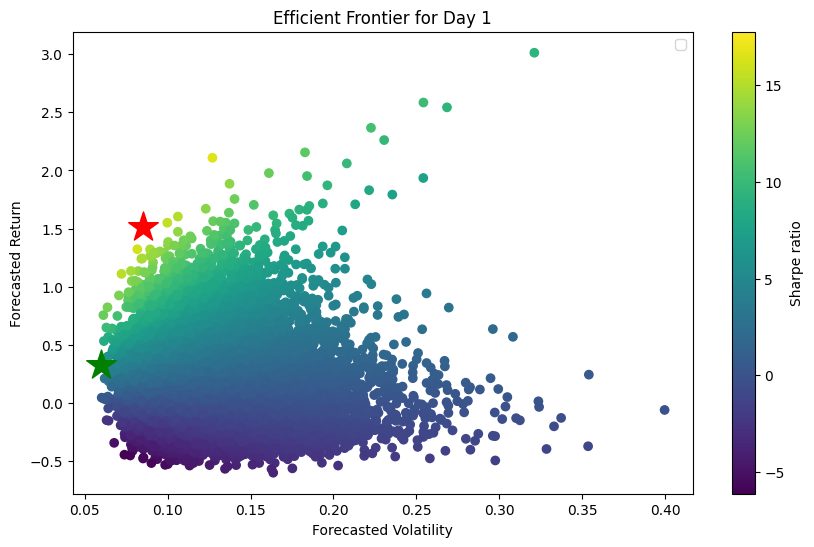

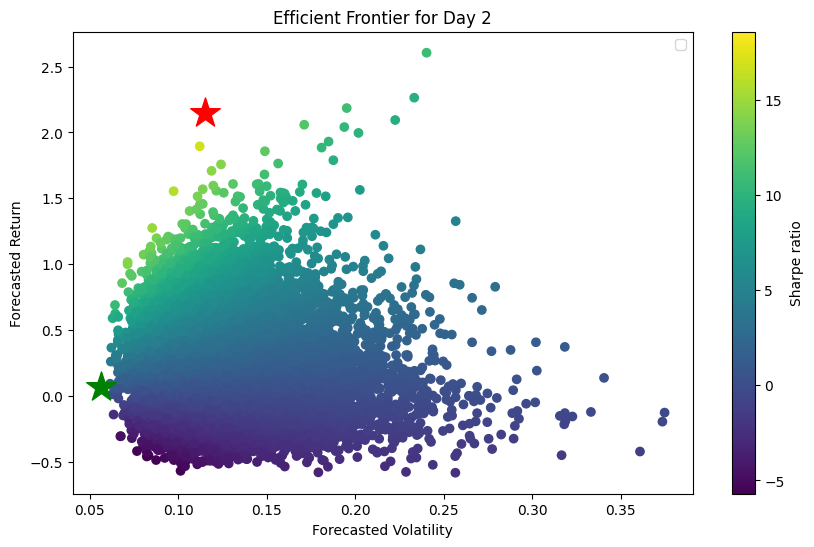

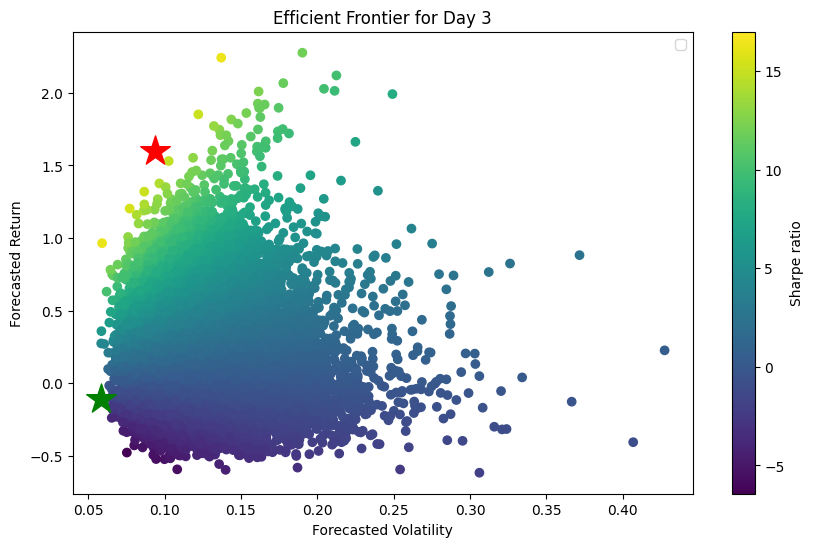

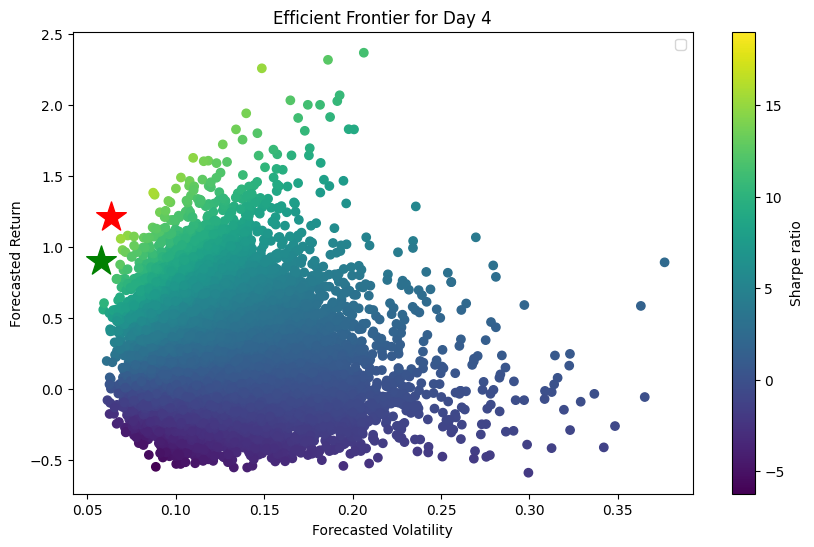

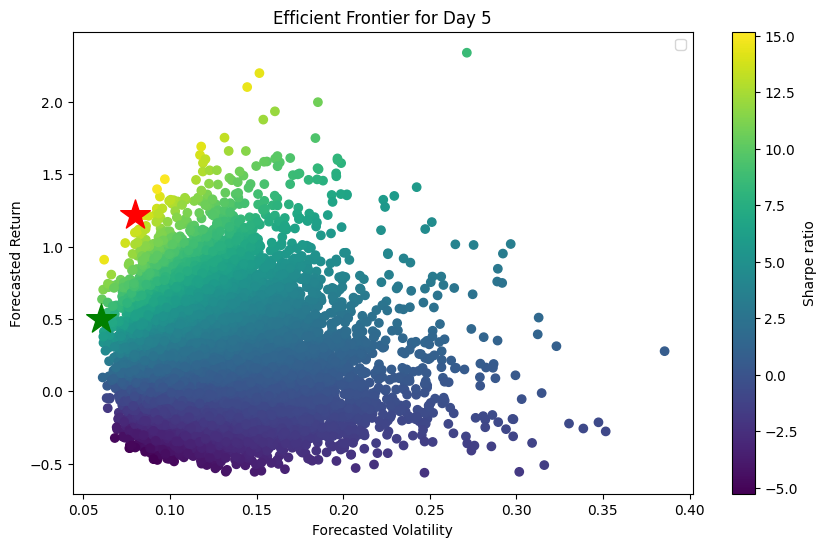

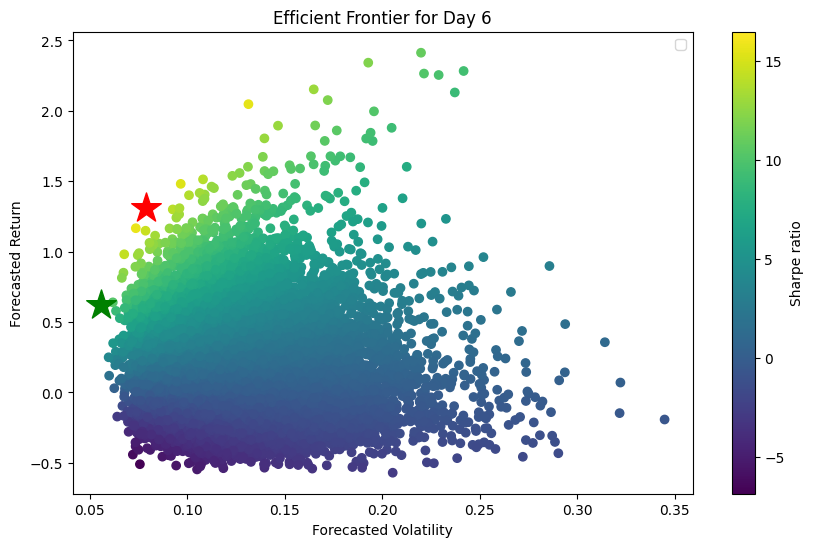

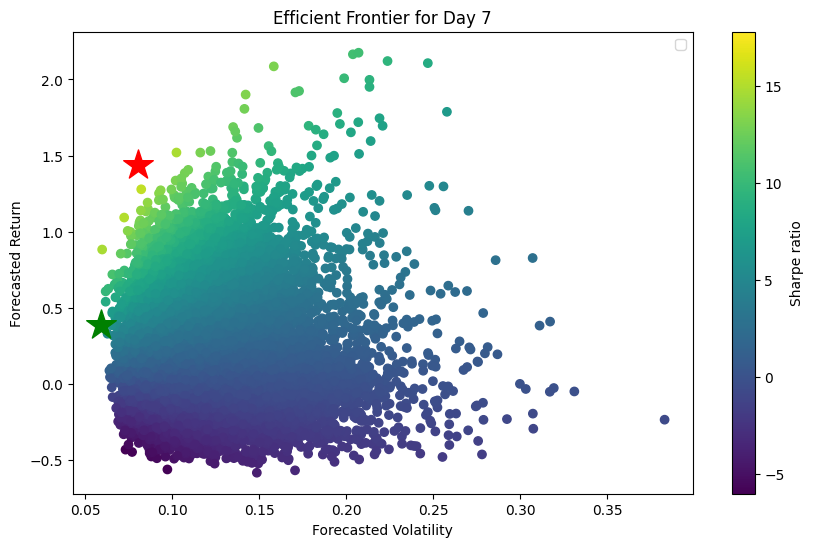

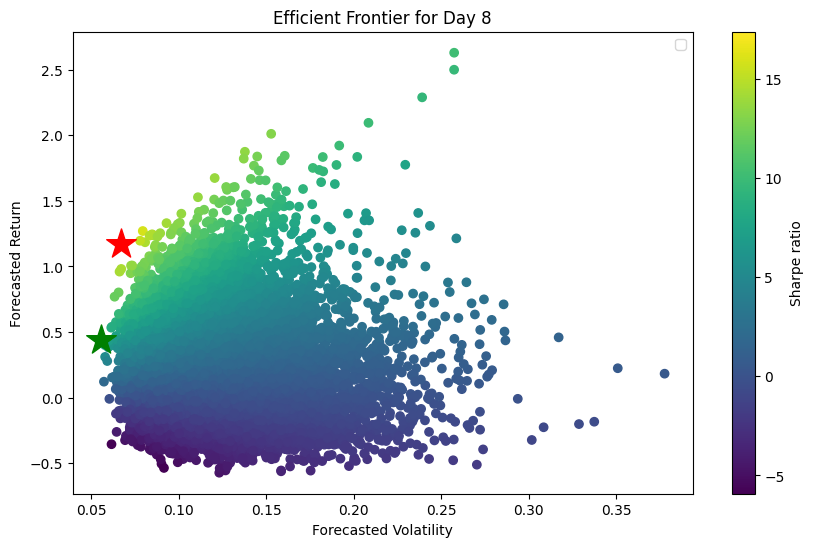

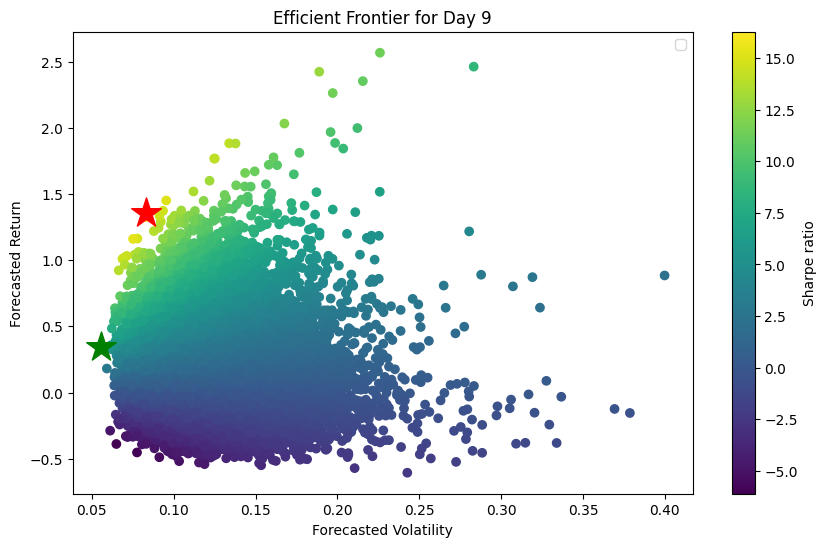

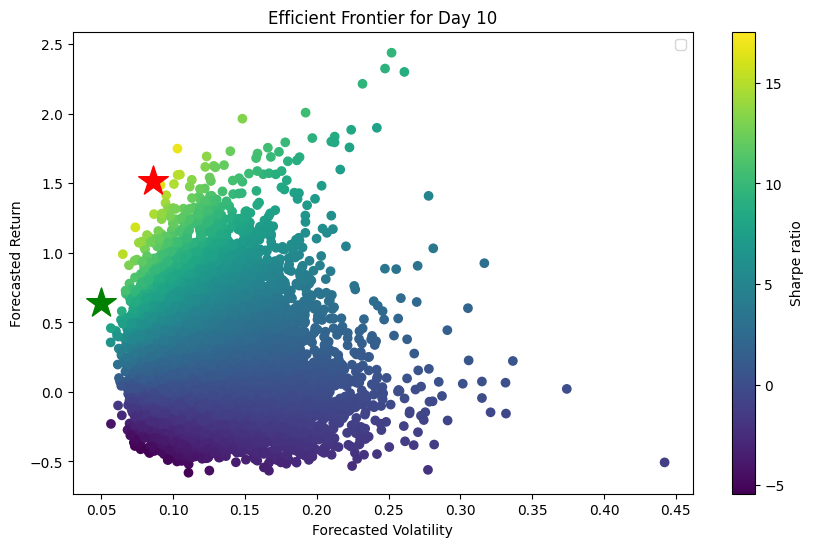

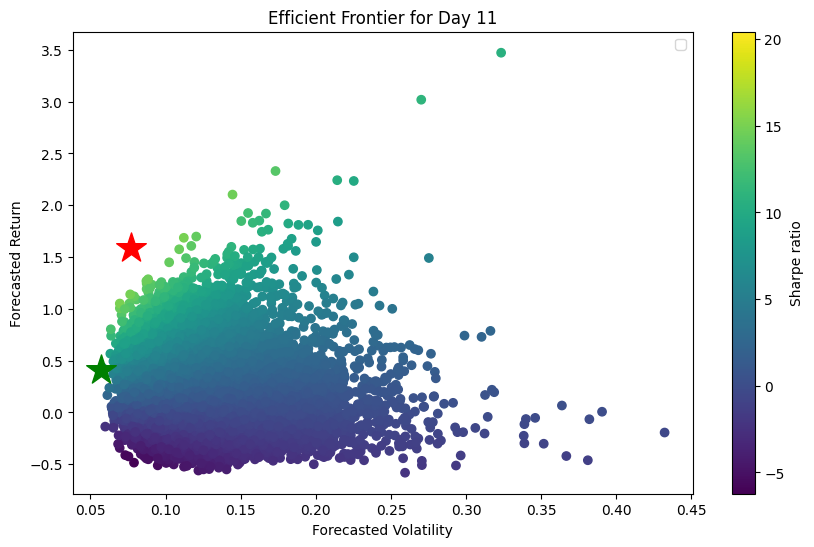

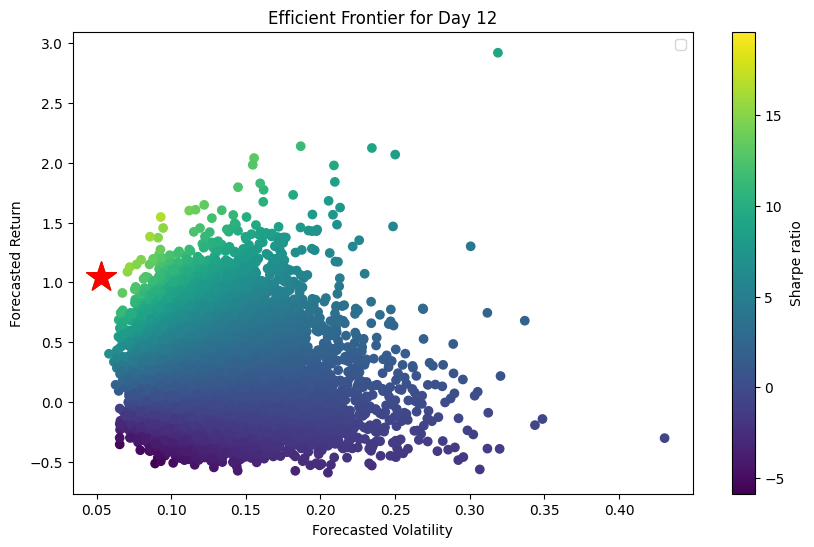

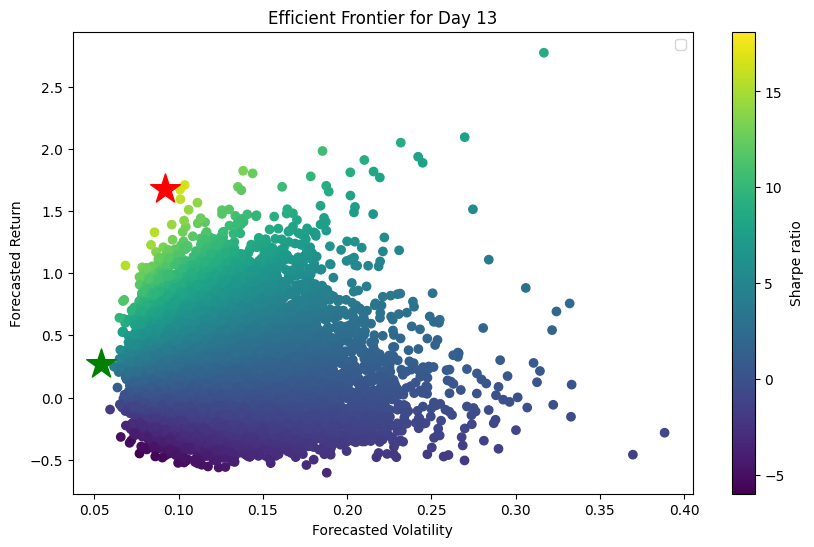

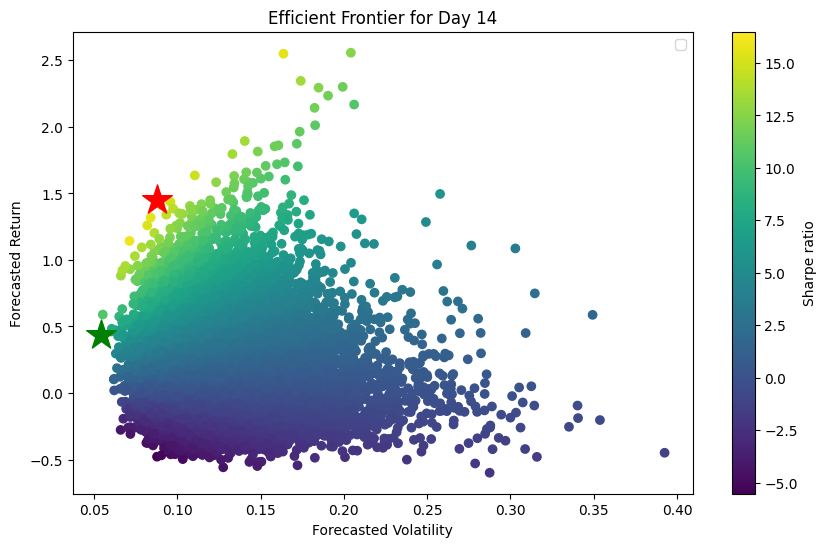

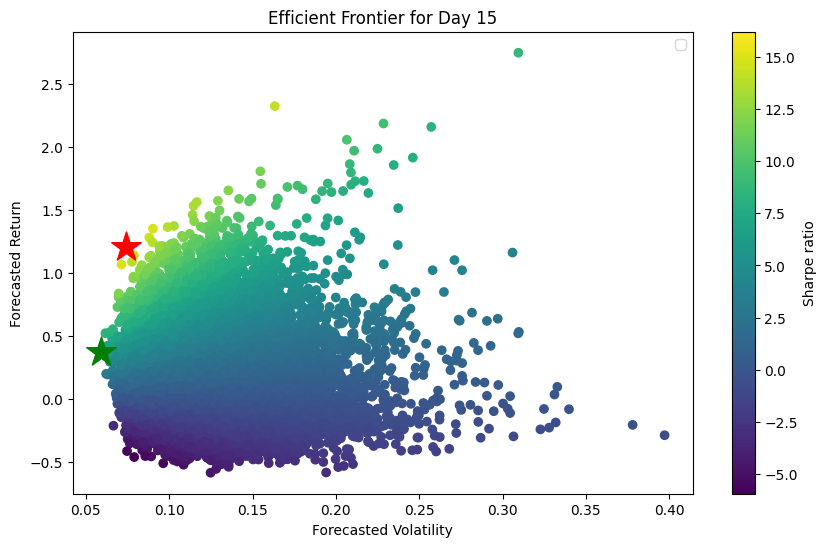

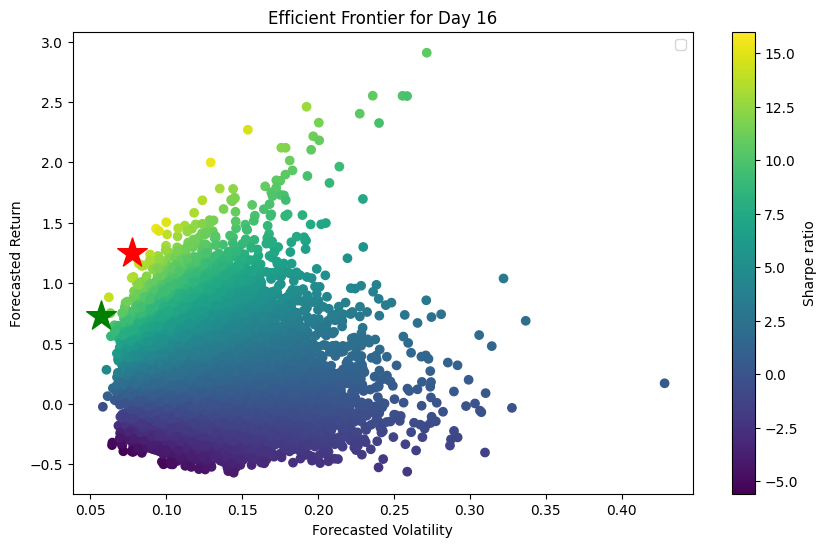

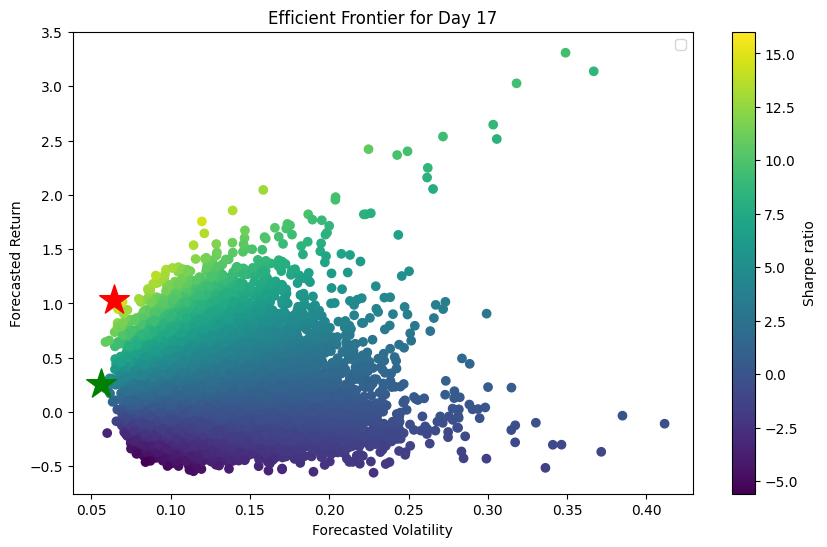

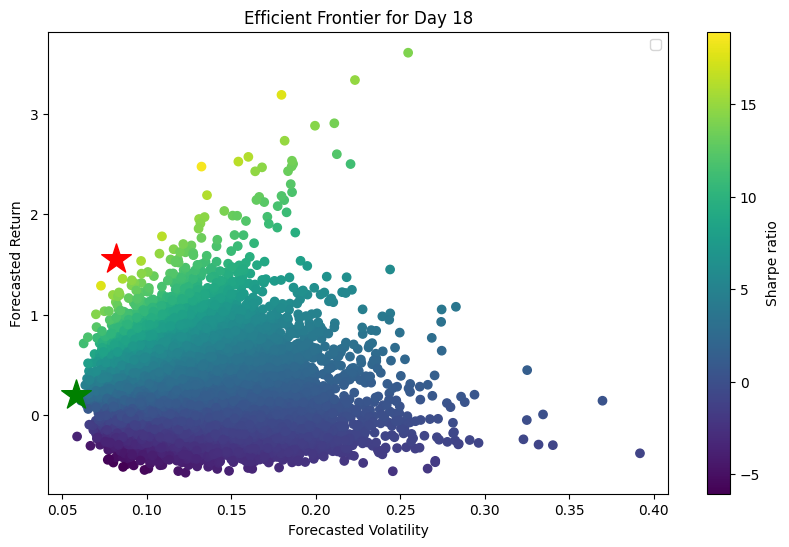

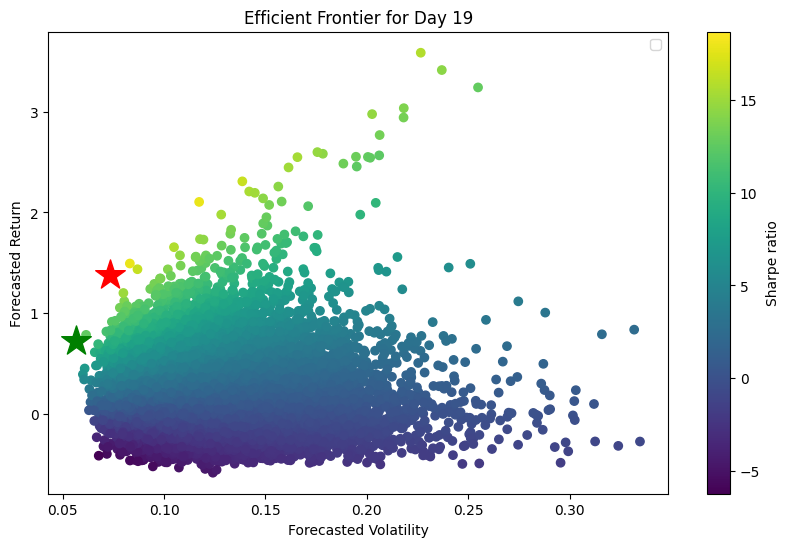

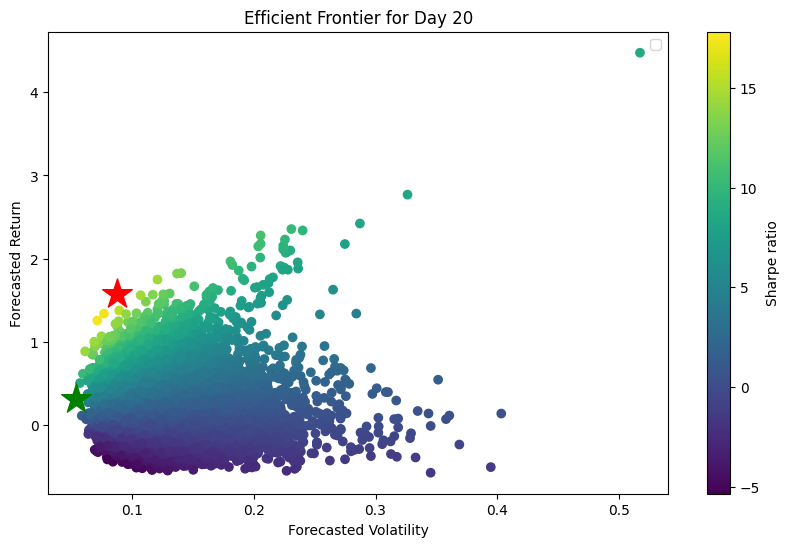

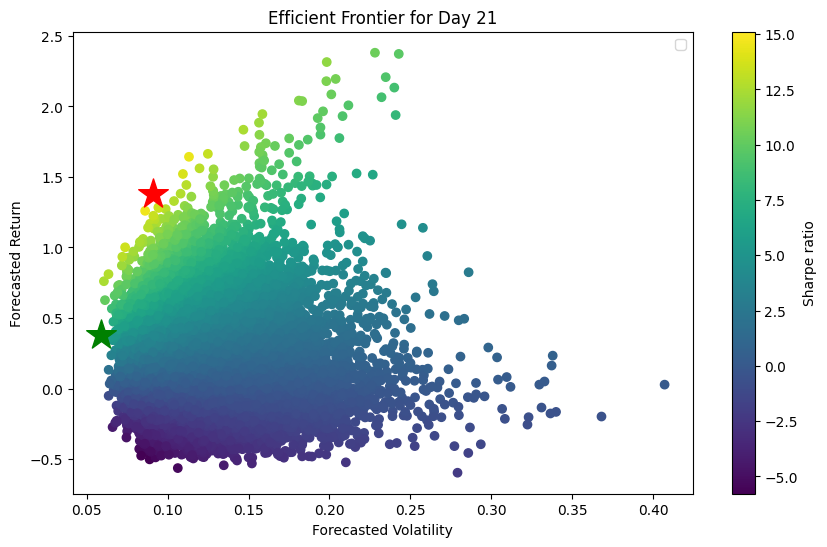

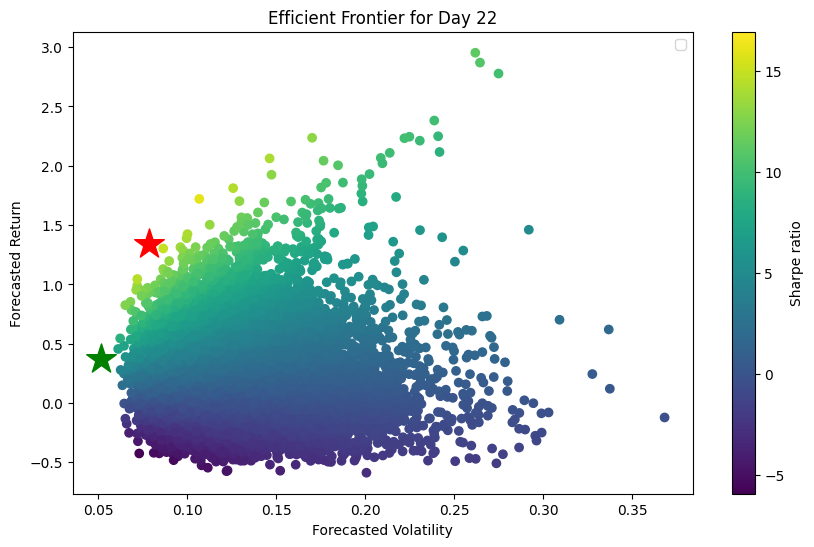

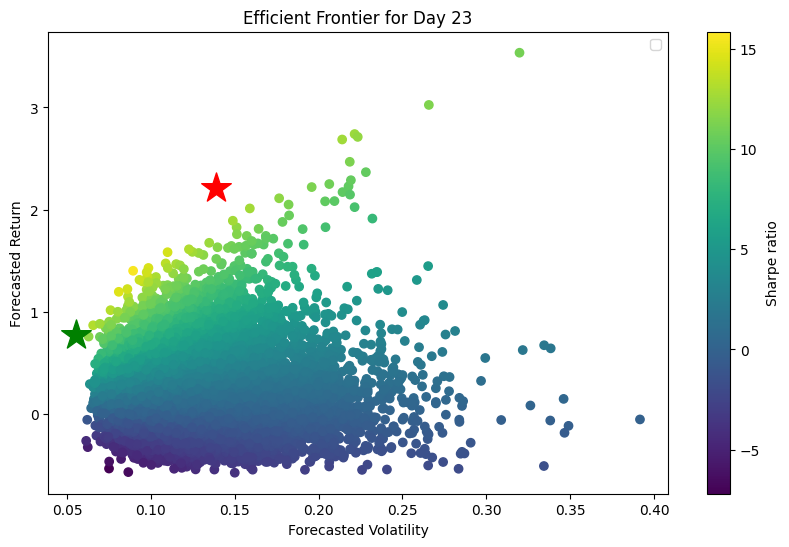

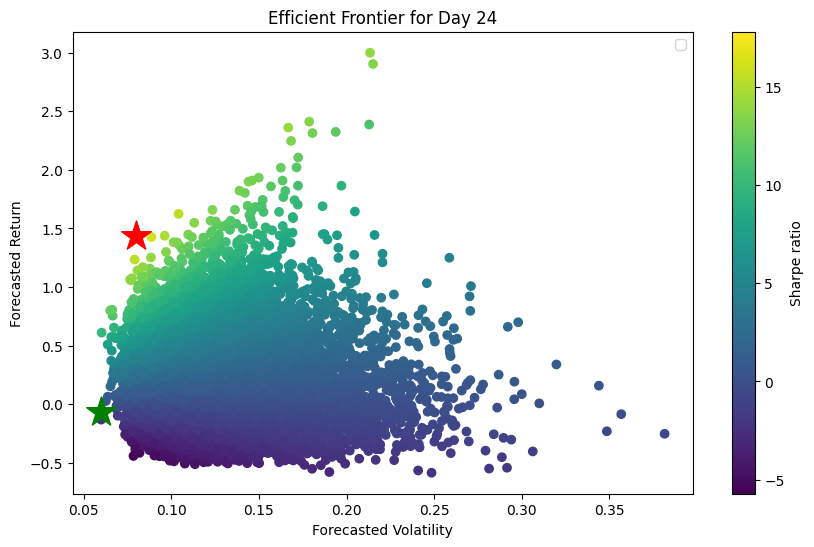

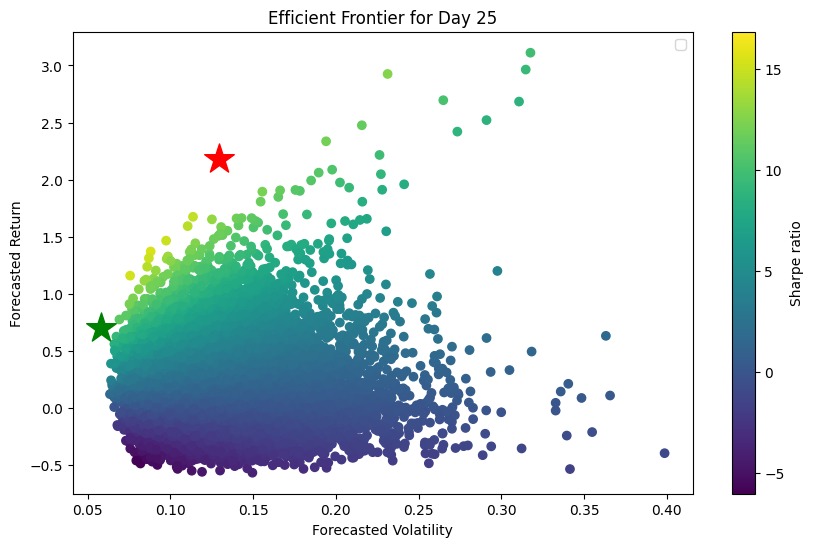

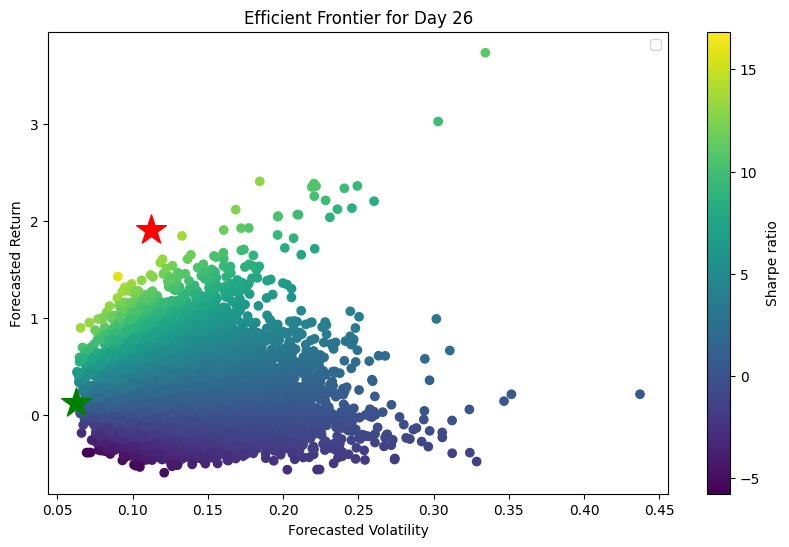

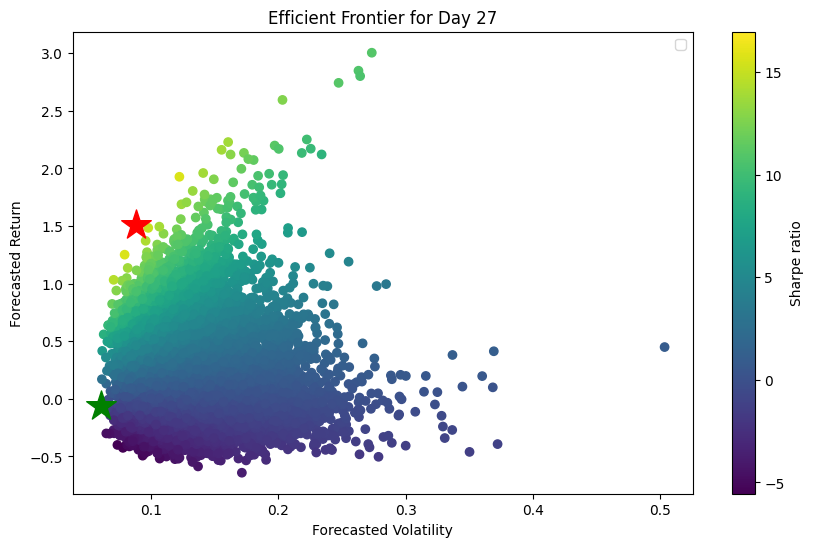

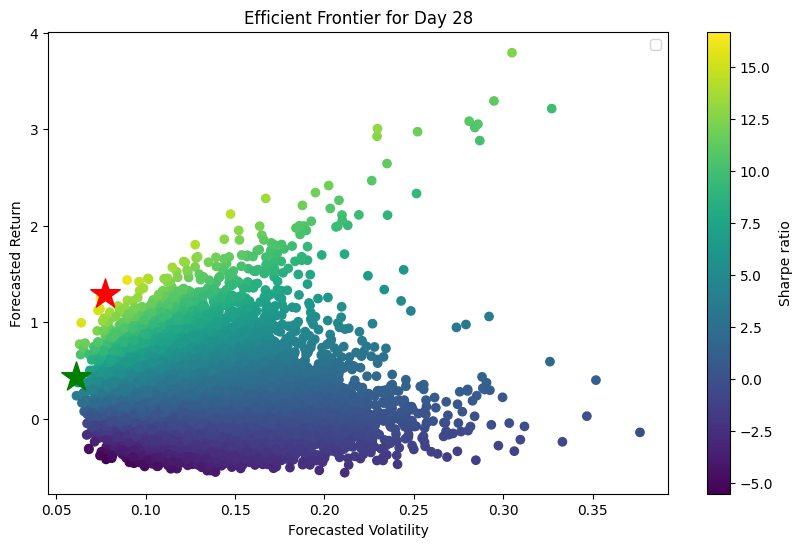

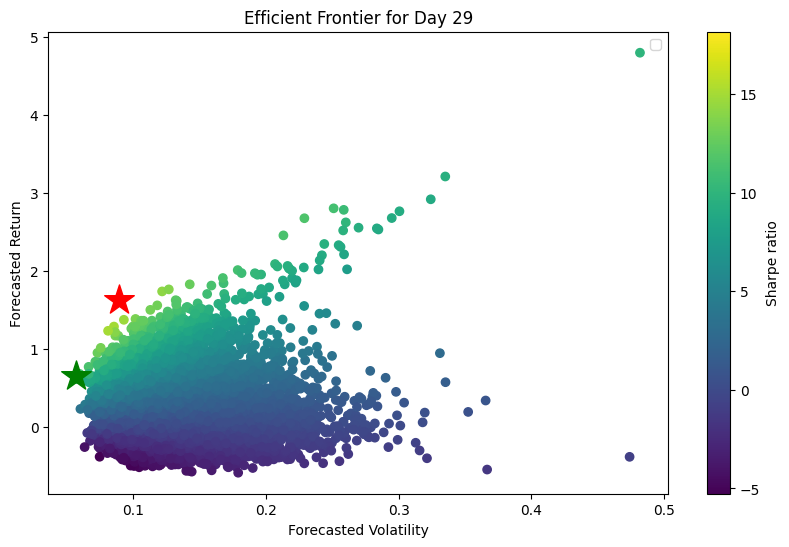

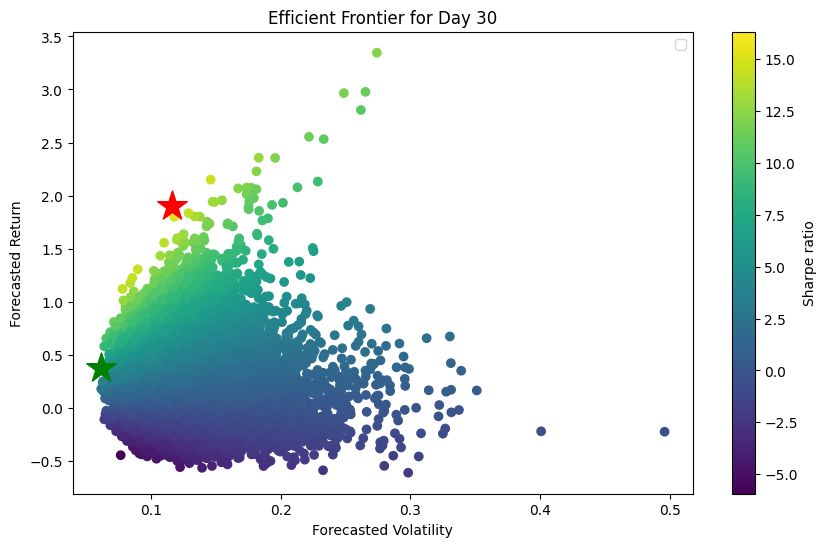

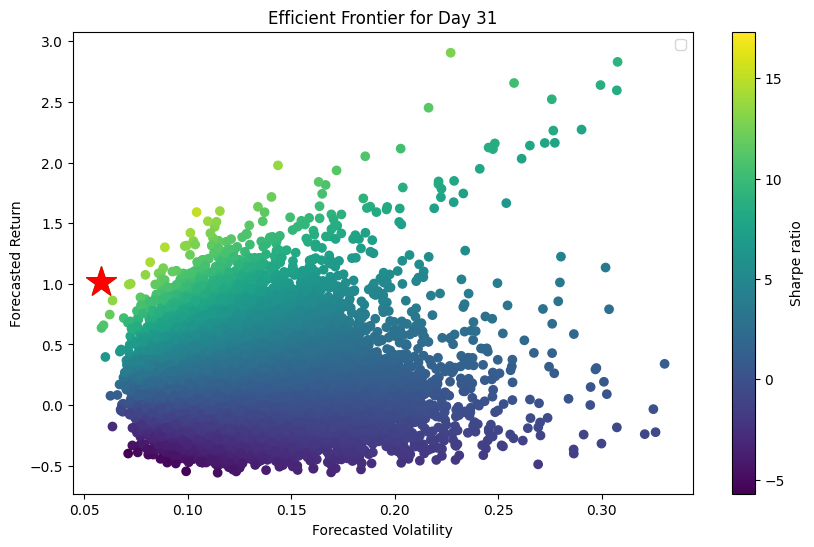

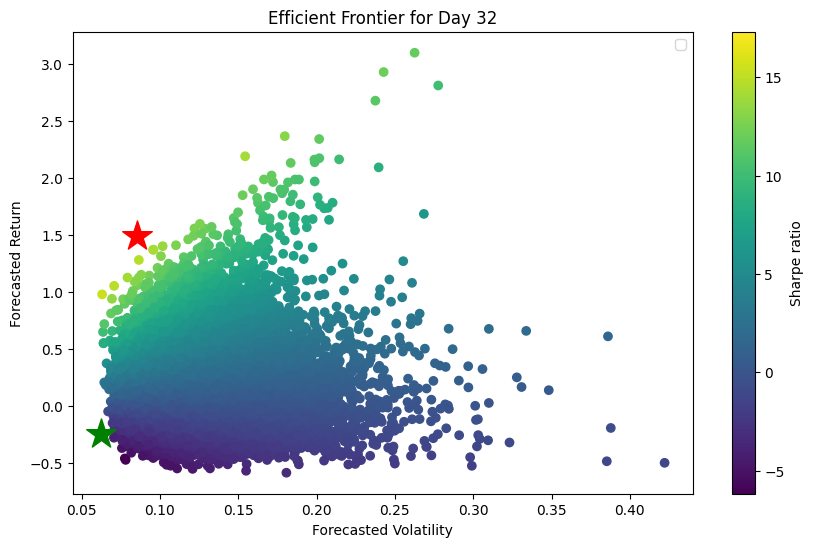

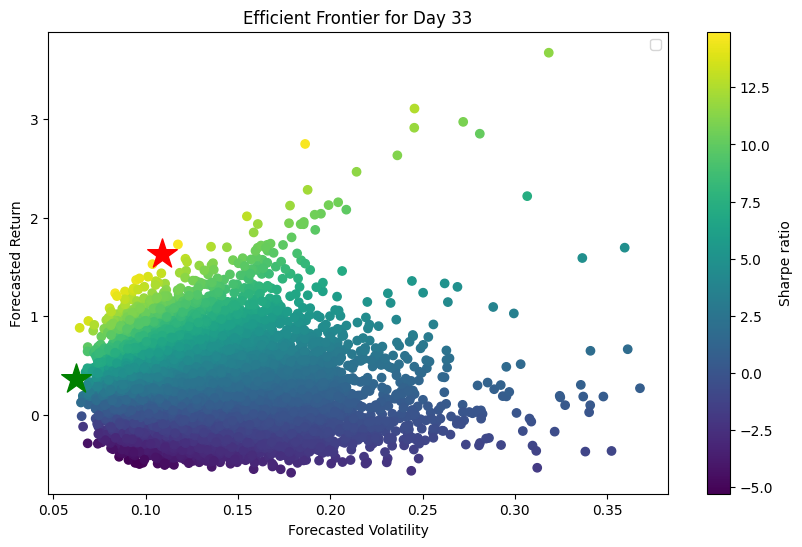

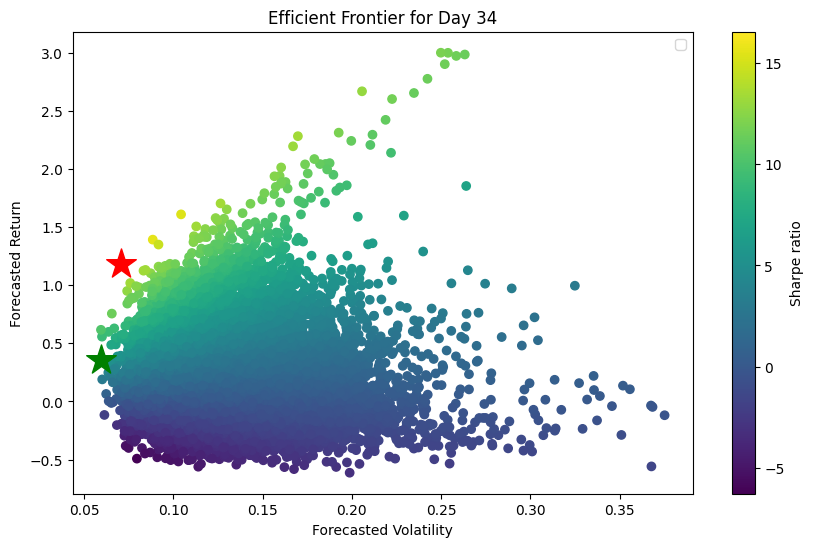

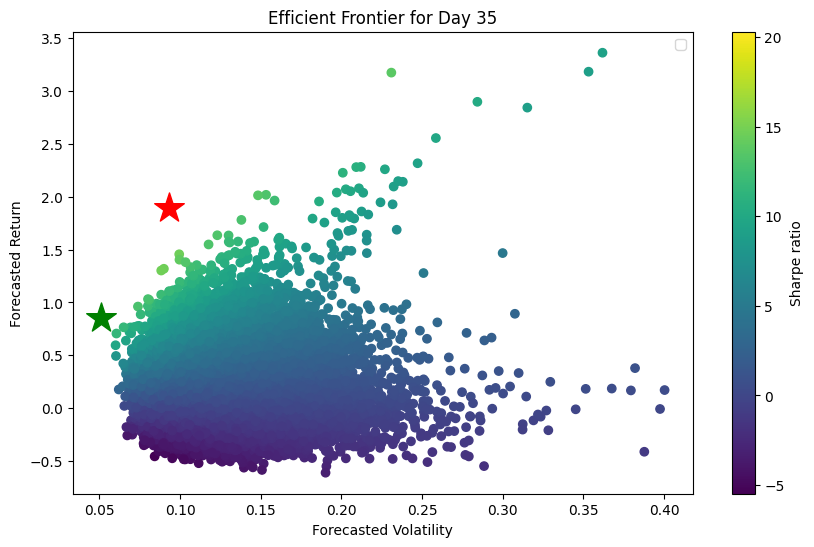

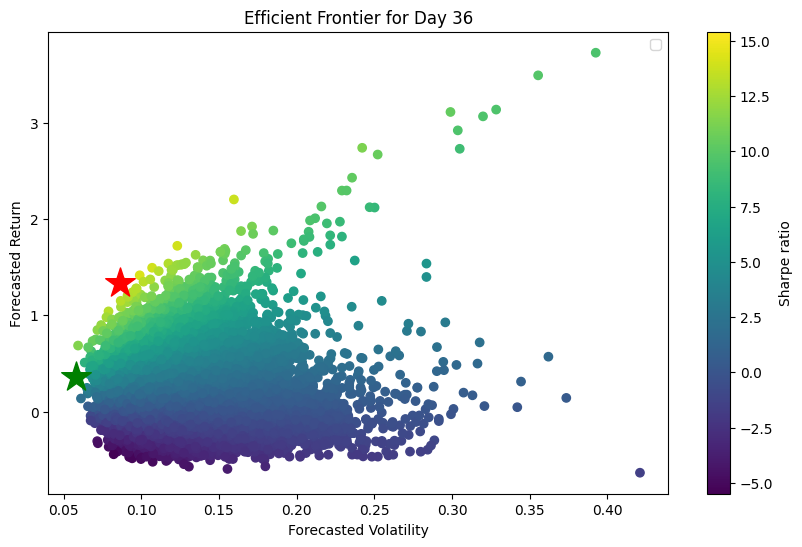

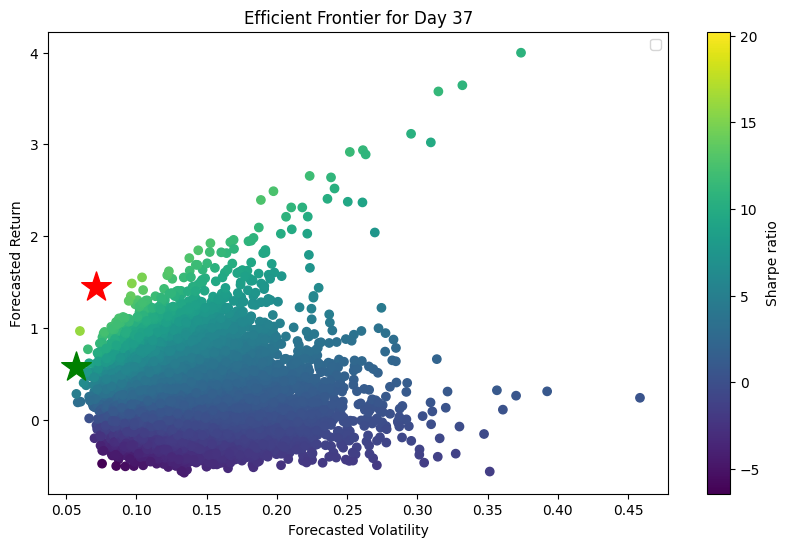

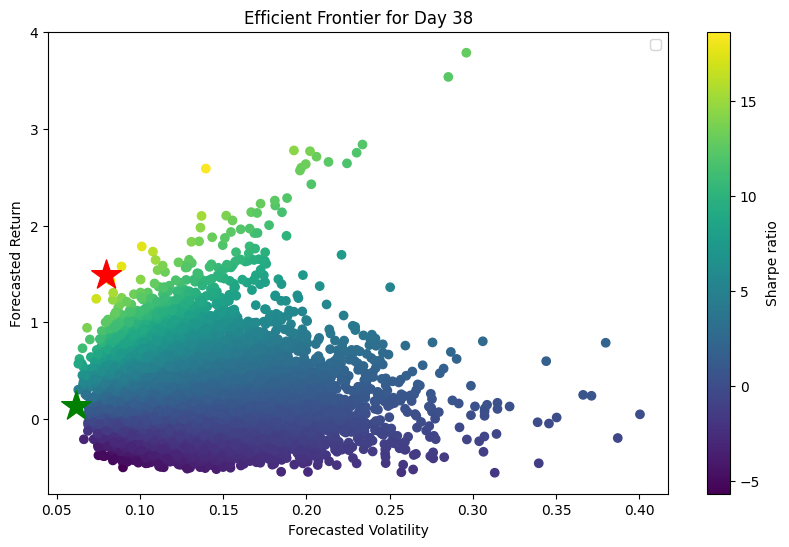

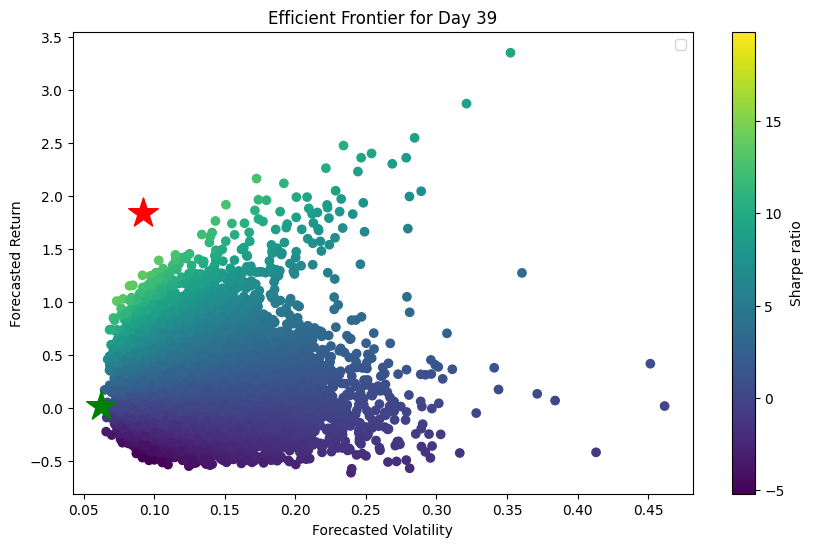

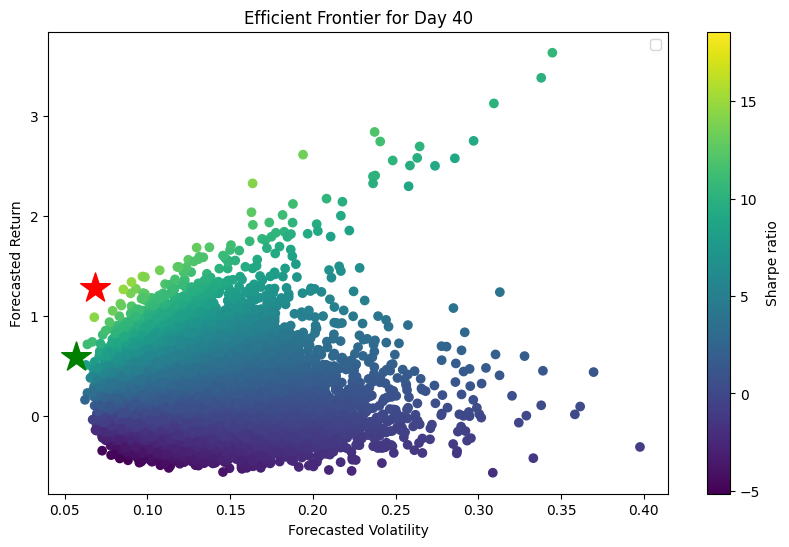

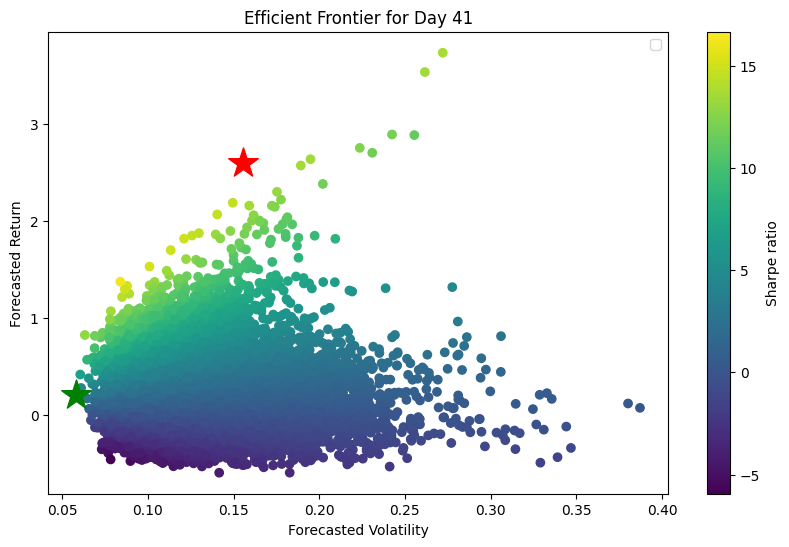

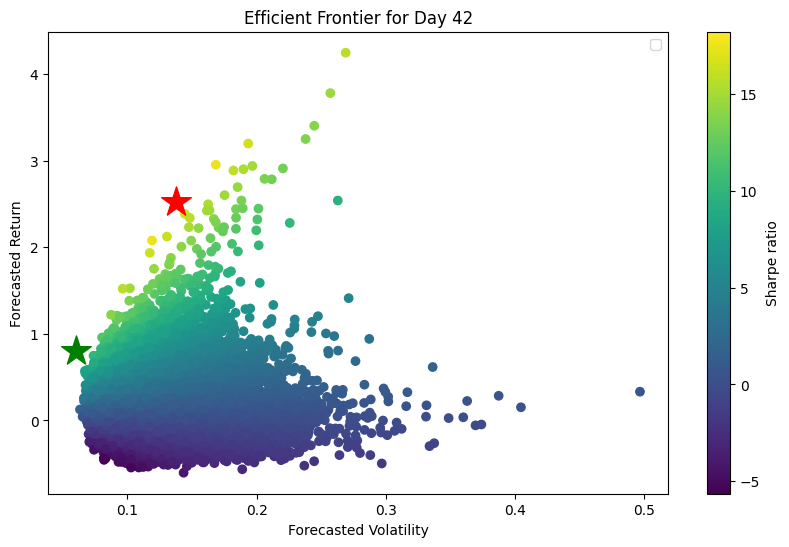

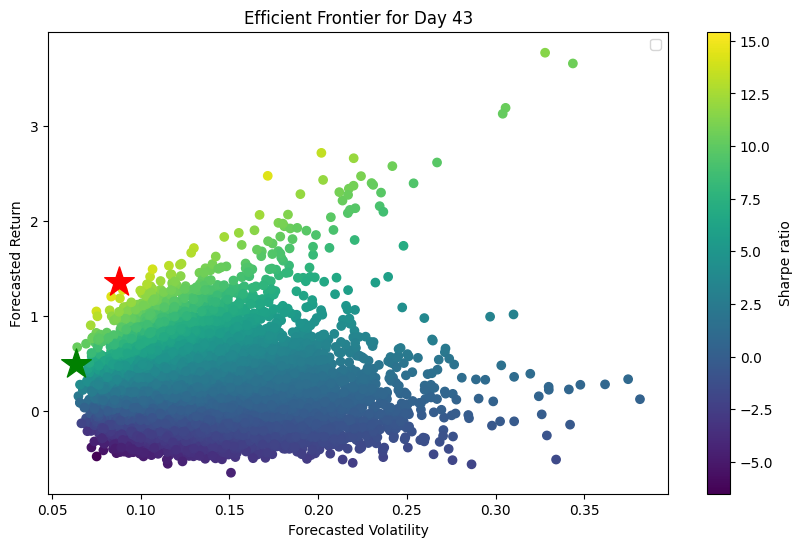

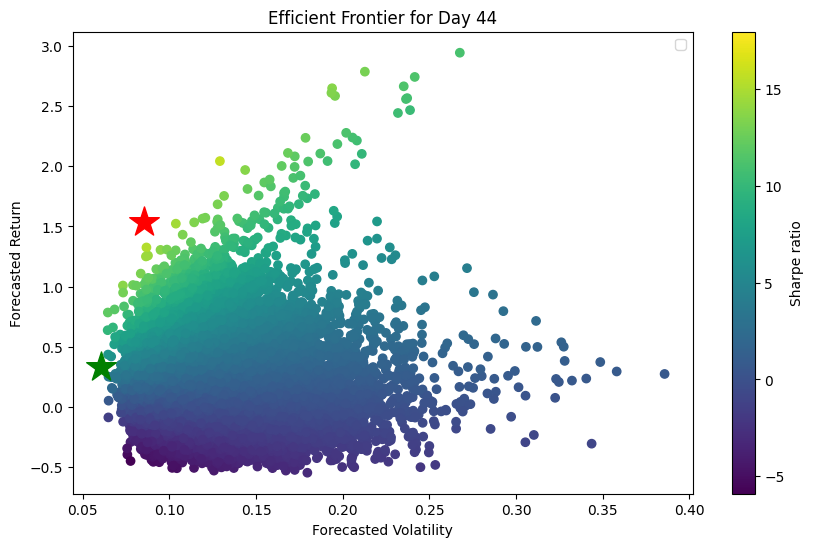

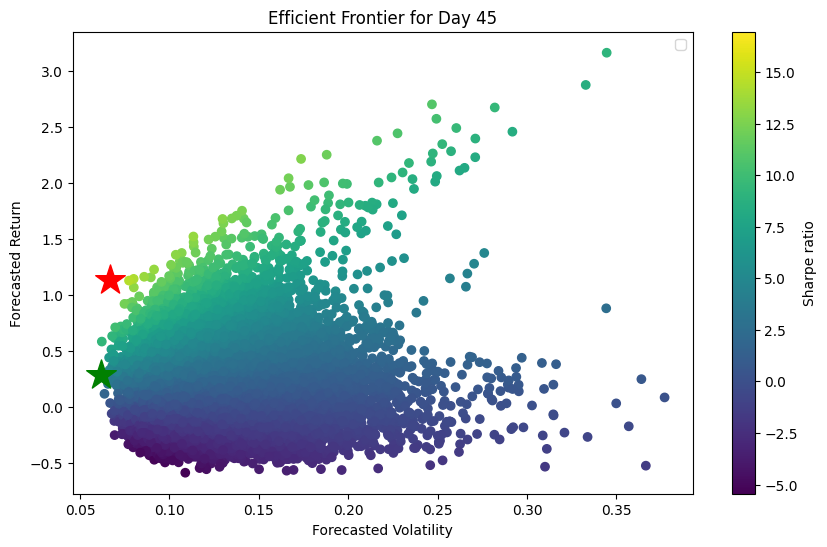

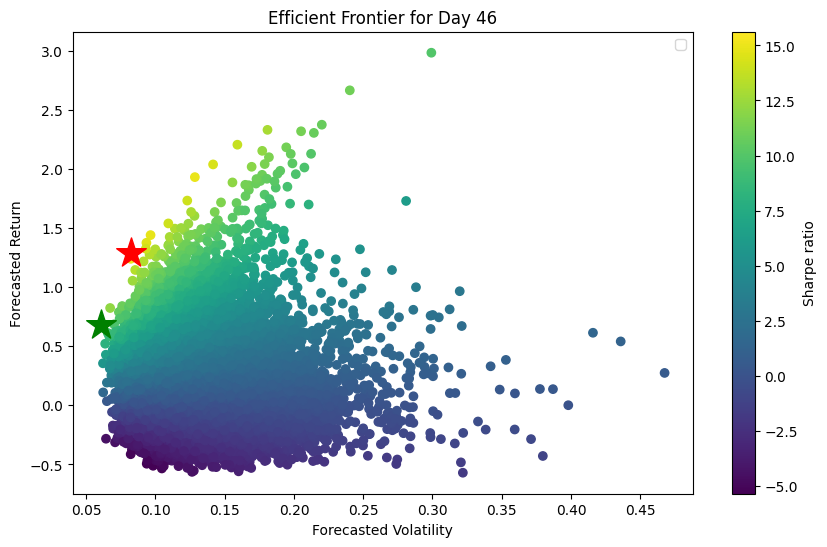

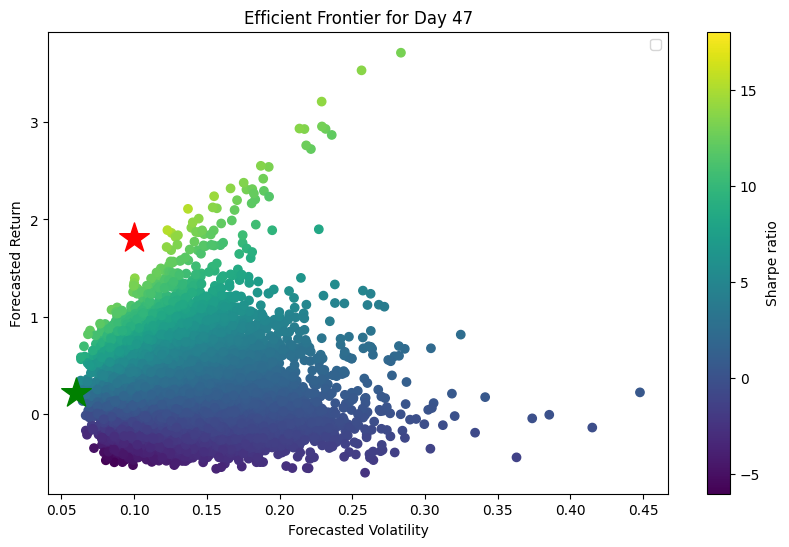

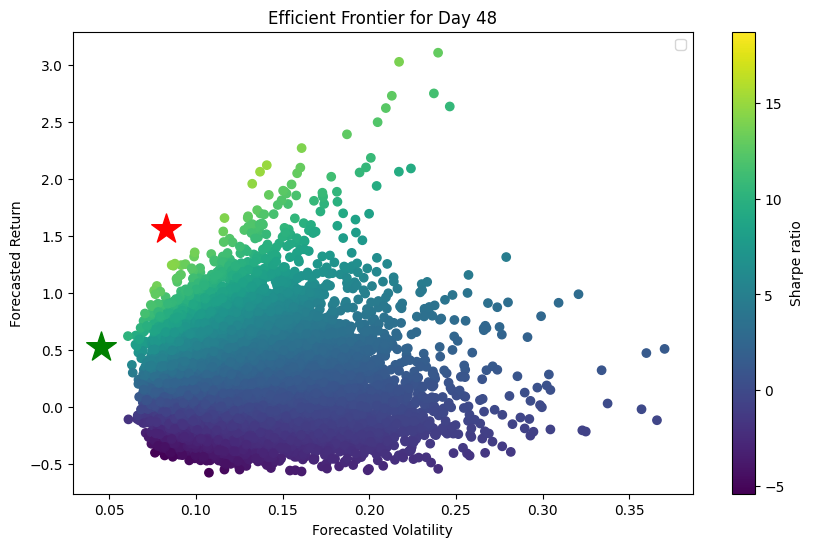

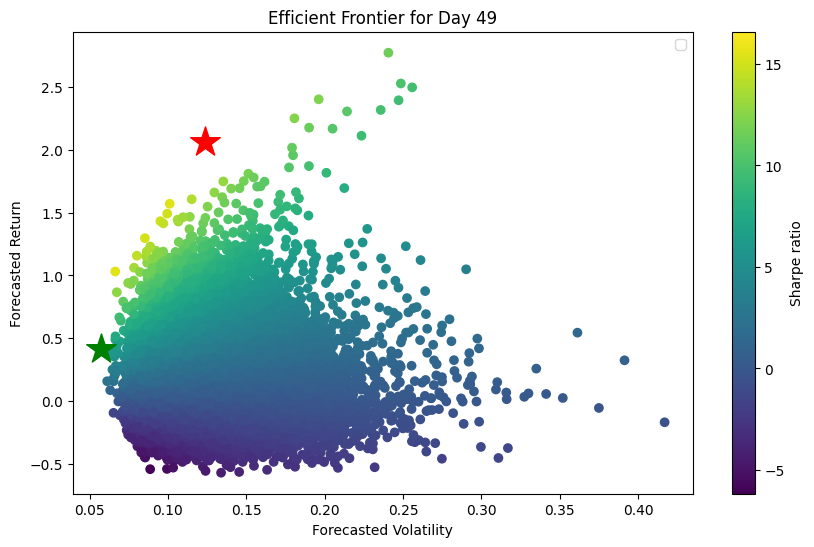

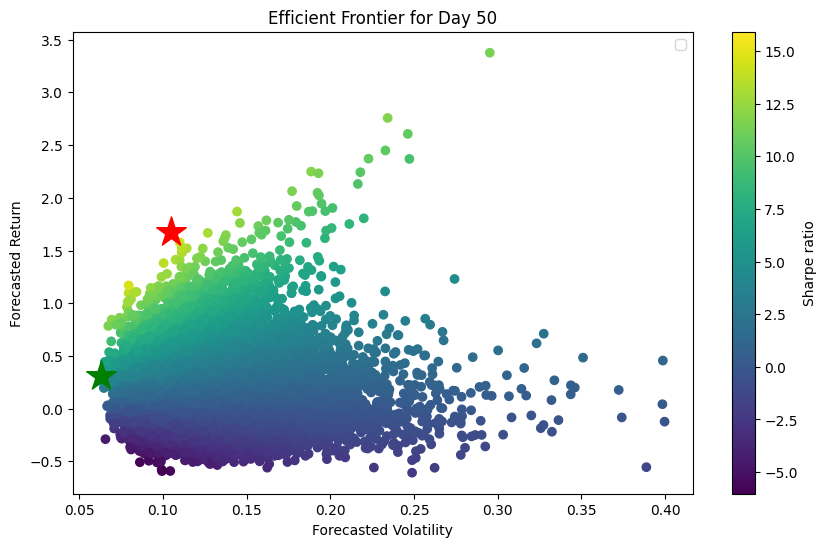

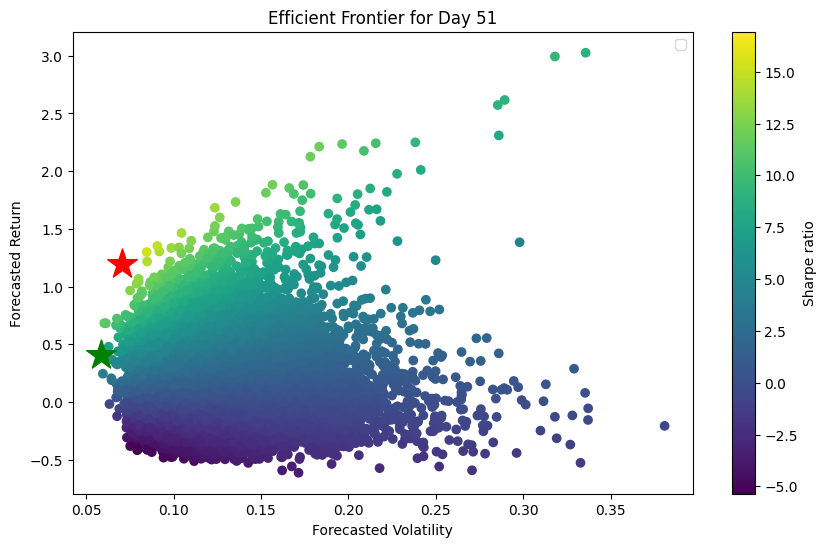

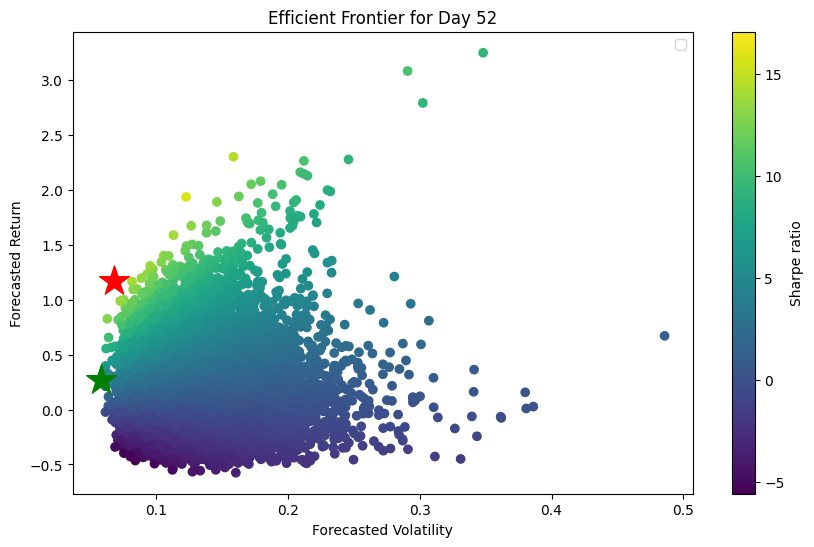

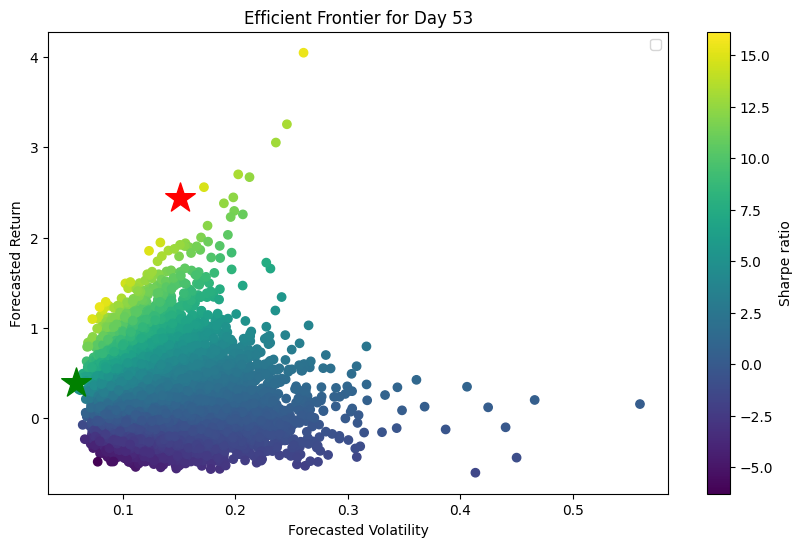

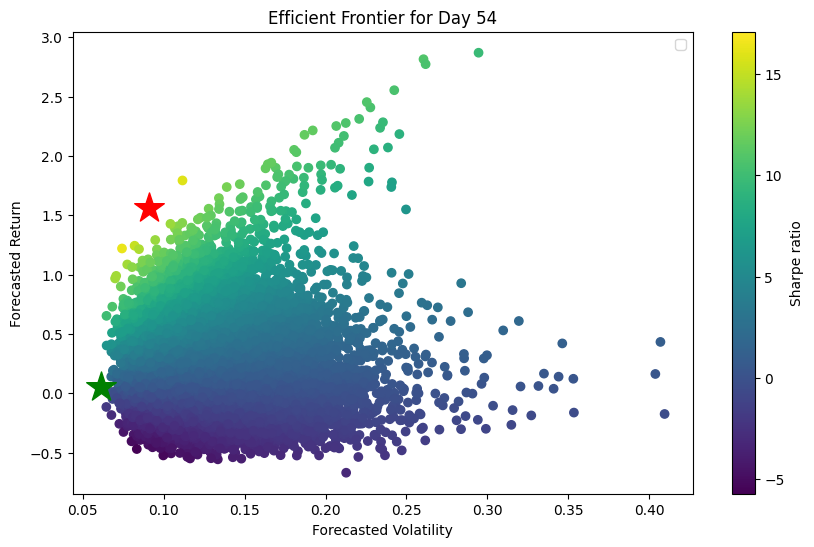

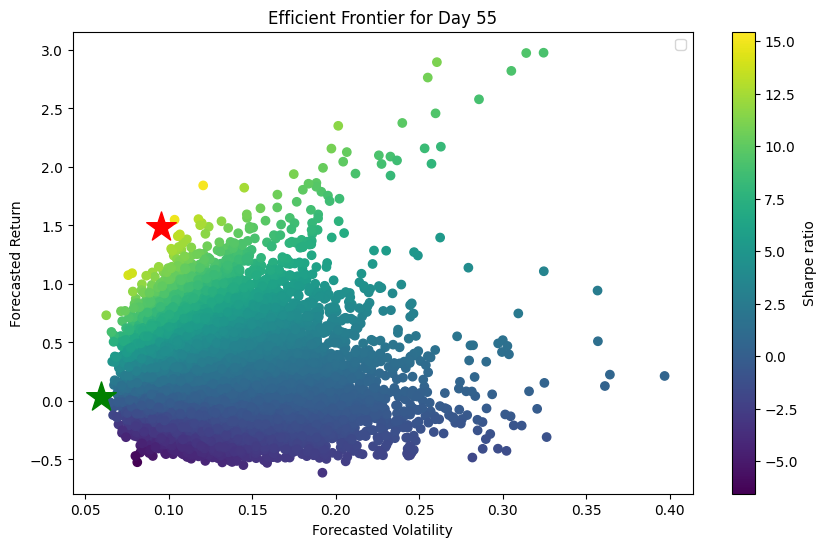

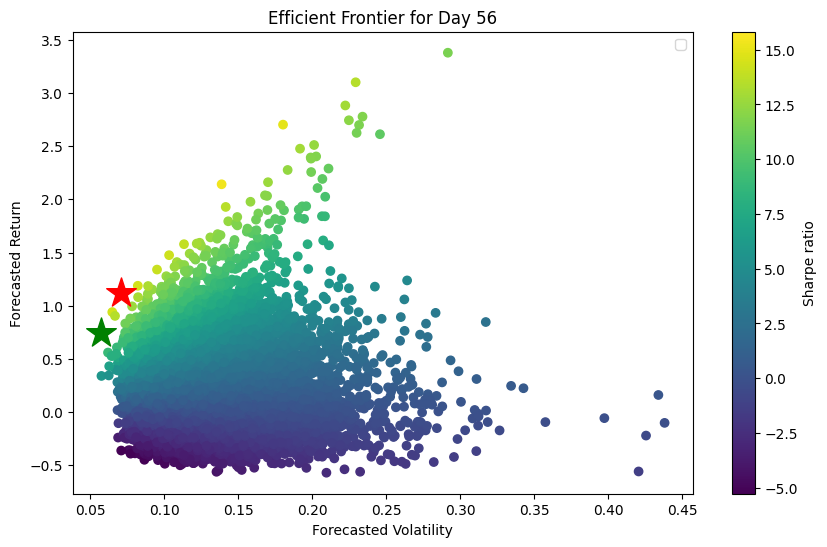

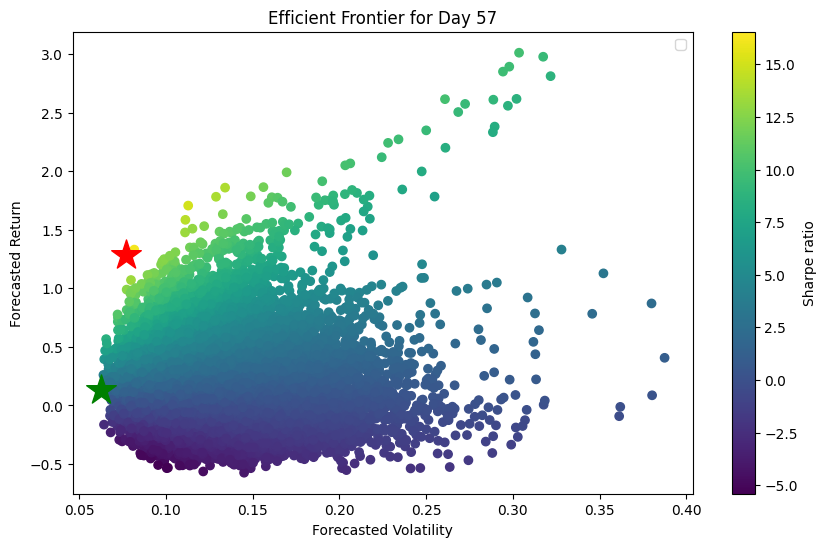

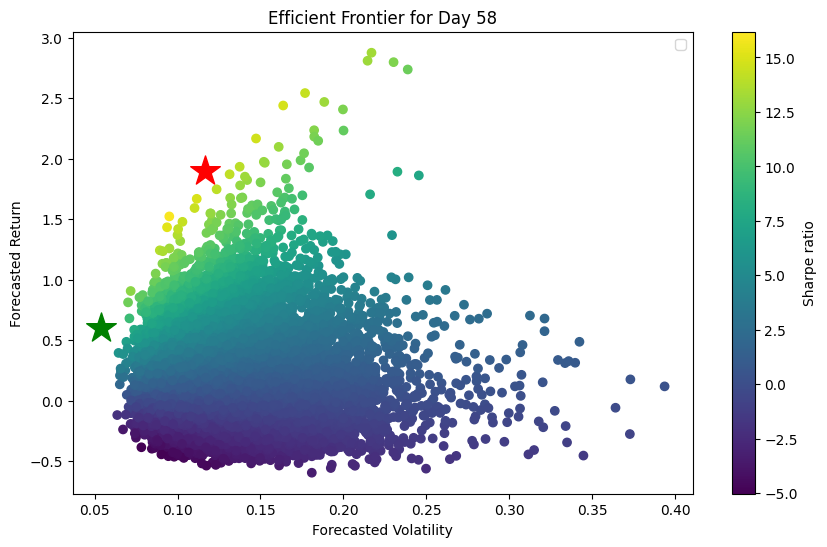

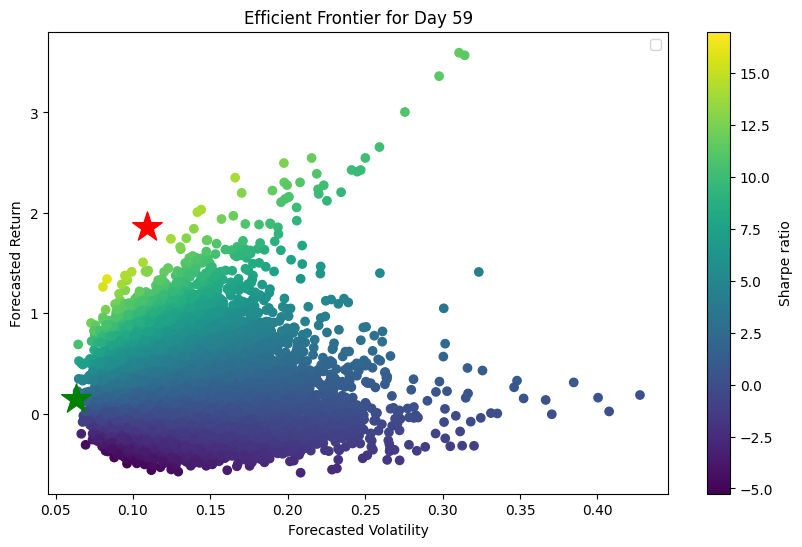

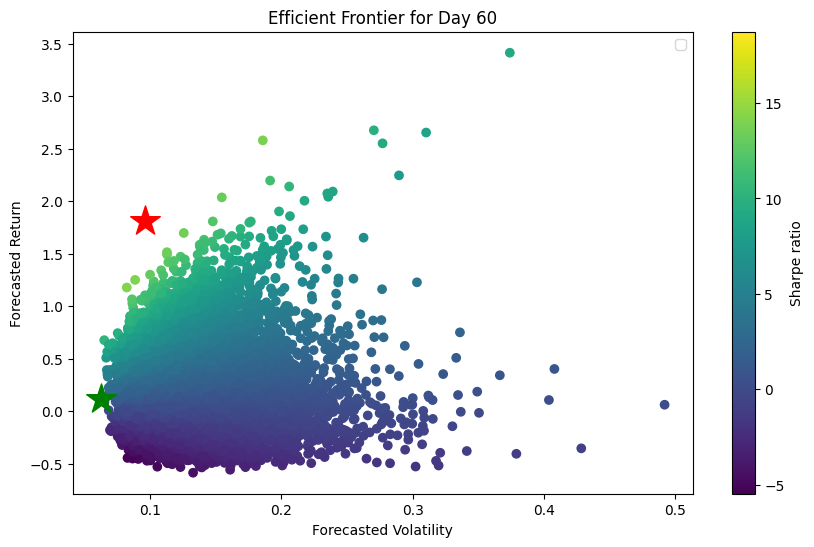

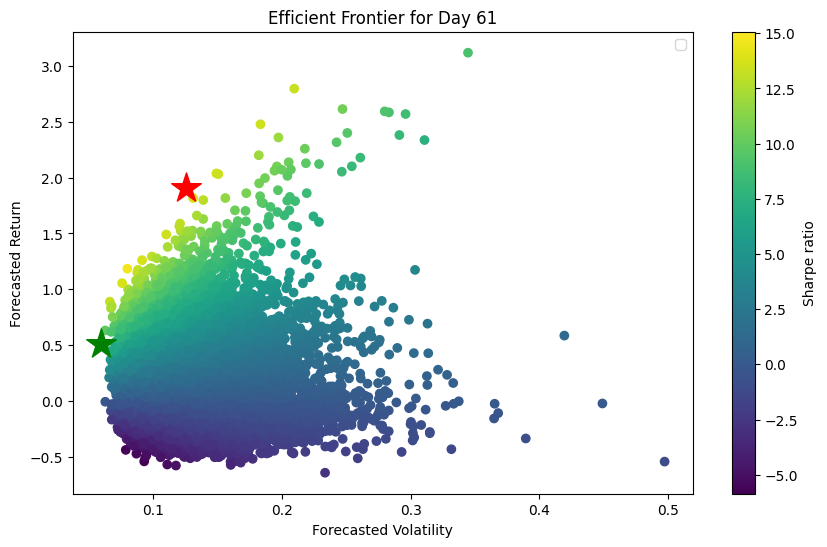

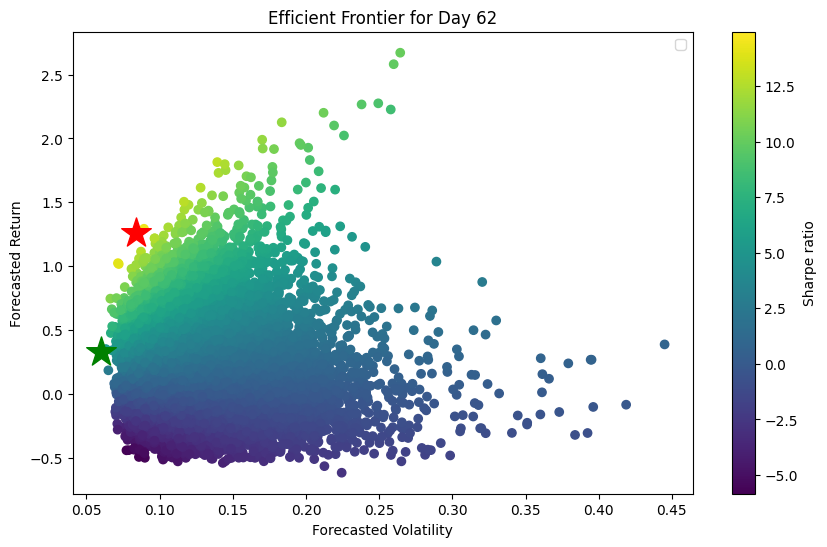

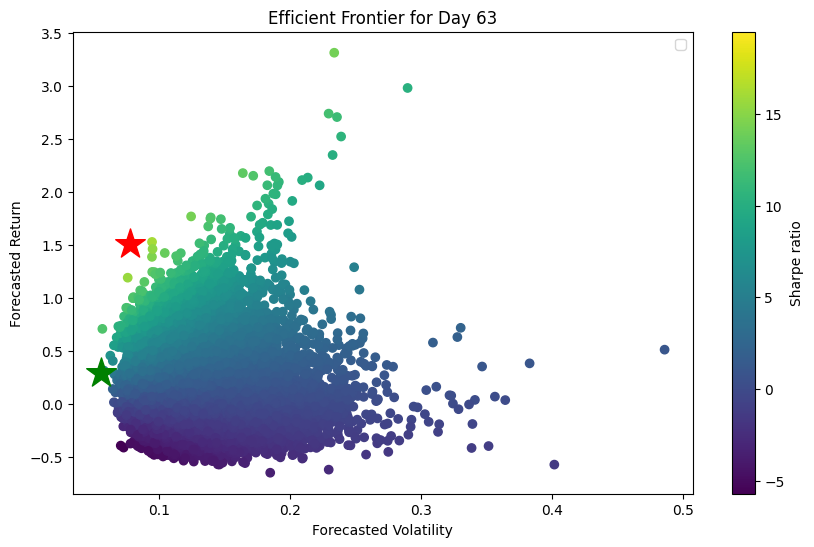

In [25]:
# Your dataframes: df_returns for daily returns, df_stds for daily standard deviations
# They should have the same shape and share indices and columns
assert pred_mean_df.shape == pred_std_df.shape
assert (pred_mean_df.index == pred_std_df.index).all()
assert (pred_mean_df.columns == pred_std_df.columns).all()

# Set up an array to hold results
n_days, n_assets = pred_mean_df.shape

n_portfolios = 20000  # number of portfolios to simulate each day

optimal_portfolios = {}
# convert the datetime index to string for the variable
days = pred_mean_df.index.strftime('%Y-%m-%d')

# Run simulation for each day
for i in range(n_days):
    # Get mean returns and standard deviations for the day
    means = pred_mean_df.iloc[i].values
    stds = pred_std_df.iloc[i].values

    # Calculate the covariance matrix based on the predicted stds
    cov_matrix = np.diag(stds**2)

    # Arrays to store simulation results
    portfolio_returns = []
    portfolio_risks = []
    portfolio_weights = []
    portfolio_sharpe_ratios = []

    # Generate random portfolios
    for _ in range(n_portfolios):
        random_indices = np.random.choice(n_assets, size=10, replace=False)  # Randomly select 10 indices
        weights = np.zeros(n_assets)  # Initialize weights array
        weights[random_indices] = np.random.dirichlet(np.ones(10))  # Generate random weights for selected indices
        portfolio_weights.append(weights)
    
        # weights = np.random.dirichlet(np.ones(n_assets))  # generate random weights
        # portfolio_weights.append(weights)

        # Calculate portfolio return and risk
        returns = np.dot(weights, means)
        portfolio_returns.append(returns)

        var = np.dot(weights.T, np.dot(cov_matrix, weights))
        portfolio_risks.append(np.sqrt(var))

        # Calculate Sharpe ratio
        sharpe_ratio = (returns - (0.03/4)) / np.sqrt(var) # risk free rate in last quarter of 2019 was 3%
        portfolio_sharpe_ratios.append(sharpe_ratio)

    # Convert to numpy arrays
    portfolio_returns = np.array(portfolio_returns)
    portfolio_risks = np.array(portfolio_risks)
    portfolio_weights = np.array(portfolio_weights)
    portfolio_sharpe_ratios = np.array(portfolio_sharpe_ratios)

    
    
    # Identify the portfolio with the highest Sharpe ratio
    max_index = np.argmax(portfolio_sharpe_ratios)
    optimal_risk = portfolio_risks[max_index]
    optimal_return = portfolio_returns[max_index]
    optimal_weights = portfolio_weights[max_index]
    # # only keep the weights that are > 0
    # optimal_weights = optimal_weights[optimal_weights > 0]
    # only keep the top 10 weights, but don't change the order and save their original indices
    top_10_weights = optimal_weights.argsort()[-10:][::-1]
    # # sort the weights in descending order
    optimal_weights = optimal_weights[top_10_weights]
    # make sure that the weights add up to 1
    optimal_weights = optimal_weights/sum(optimal_weights)
    # find the corresponding tickers
    optimal_tickers = pred_mean_df.columns[top_10_weights].tolist()
    print(optimal_tickers, optimal_weights, optimal_return, optimal_risk)
    
    #! saving the optimal portfolio information
    optimal_portfolios[days[i]] = {'tickers': optimal_tickers, 'weights': optimal_weights, 'return': optimal_return, 'risk': optimal_risk}
   

    # Calculate risk-free rate
    risk_free_rate = 0.03 / 4  # Assuming annual risk-free rate of 3%

    # Plot the efficient frontier for the day
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_risks, portfolio_returns, c=portfolio_sharpe_ratios, cmap='viridis', marker='o')
    plt.colorbar(label='Sharpe ratio')
    # Plot the minimum volatility portfolio
    plt.scatter(portfolio_risks[np.argmin(portfolio_risks)], portfolio_returns[np.argmin(portfolio_risks)], color='g', marker='*', s=500) # min volatility portfolio
    plt.scatter(optimal_risk, optimal_return, color='r', marker='*', s=500)  # optimal portfolio

    # Calculate CAL points
    cal_returns = np.linspace(risk_free_rate, np.max(portfolio_returns), num=100)
    cal_risks = (cal_returns - risk_free_rate) / sharpe_ratio

    plt.xlabel('Forecasted Volatility')
    plt.ylabel('Forecasted Return')
    plt.title(f'Efficient Frontier for Day {i+1}')
    plt.legend()
    # plt.show()


In [26]:


#! Save the optimal weights and tickers to a csv file
# fill the rows with the optimal weights
optimal_weights_df = pd.DataFrame.from_dict(optimal_portfolios, orient='index')
# set index from pred_index_df.index
optimal_weights_df.index = pred_index_df.index
# optimal_weights_df

In [27]:
optimal_weights_df.to_csv("data/LSTM_results_optimal.csv", index=True)

tickers  \
Date                                                            
2019-10-01  [IRM, IPG, COO, WM, MDT, HII, JKHY, EXPE, INCY...   
2019-10-02  [ETSY, TSLA, ABBV, GL, LYV, PCAR, DISH, ZTS, O...   
2019-10-03  [IRM, XEL, LYV, CTLT, FMC, RF, EOG, VTRS, CRL,...   
2019-10-04   [KR, KDP, GE, CAG, EA, EIX, ISRG, IBM, IFF, MAA]   
2019-10-07  [LYB, COP, VFC, KDP, FANG, ZBRA, LOW, SEDG, MC...   
...                                                       ...   
2019-12-23  [HSIC, SYK, GOOGL, PCAR, RF, TXN, NOW, MS, MCK...   
2019-12-24  [IRM, RF, FDX, KDP, MMC, HST, PODD, VZ, NVR, M...   
2019-12-26  [RF, PODD, ABBV, HON, NXPI, ENPH, KDP, WAB, FM...   
2019-12-27  [IRM, BLK, SBUX, KEY, AXON, REGN, CMS, SNPS, L...   
2019-12-30  [IRM, FITB, FDX, YUM, JNPR, GM, PKG, PEAK, AXO...   

                                                      weights    return  \
Date                                                                      
2019-10-01  [0.3396945322609241, 0.1682237558206111, 0.126...  1.513563   
2019-10-02  [0.3331636247118823, 0.1657307471393384, 0.136...  2.150309   
2019-10-03  [0.29734247606037356, 0.18680776738040342, 0.1...  1.599994   
2019-10-04  [0.30037198568202694, 0.21630163372875122, 0.1...  1.209262   
2019-10-07  [0.4661418638682895, 0.144016803391382, 0.1185...  1.220697   
...                                                       ...       ...   
2019-12-23  [0.2696113650604912, 0.2323446188206735, 0.169...  1.862451   
2019-12-24  [0.39085902759717034, 0.1910606429273615, 0.15...  1.813370   
2019-12-26  [0.2711400063614656, 0.19328535492639917, 0.18...  1.906068   
2019-12-27  [0.38778772043977927, 0.2408300503966578, 0.08...  1.261833   
2019-12-30  [0.41732307535053315, 0.2510586413180048, 0.18...  1.515463   

                risk  
Date                  
2019-10-01  0.084867  
2019-10-02  0.115368  
2019-10-03  0.093689  
2019-10-04  0.063209  
2019-10-07  0.079940  
...              ...  
2019-12-23  0.109088  
2019-12-24  0.096368  
2019-12-26  0.125994  
2019-12-27  0.083916  
2019-12-30  0.077386  

[63 rows x 4 columns]